## Esmeralda z-effect study

## DSP Correlations

### GD/ JAH   17/10/19

In [1]:
import time
print(time.asctime())

Wed Nov 13 18:06:17 2019


In [2]:
%load_ext autoreload
%autoreload 2

import numpy             as np
import pandas            as pd
import tables            as tb
import matplotlib.pyplot as plt
import utils             as ut

import invisible_cities.core.fit_functions as fitf

to_df = pd.DataFrame.from_records

## Get data

In [3]:
#datadir  = "/home/jrenner/analysis/7431/hdf5/JJ_maps_100_7430_7433/ntuple/trigger2"
#filename = "/ntuple_9040_7431_trigger2_v1.1.0_20190801_bg.h5"

date        = '1112_15_5s' #'1108_15' #'1111_15_10s' # '1108_15'# , '1108_15' # '1108', 1030'
type_peak   = 'dspsel'
write       = False
ifile       = f"/home/hernando/ICAROSNB/JAH/esmes/df_7430_7435_{type_peak}_{date}.h5" 
alpha       = 0.05 if type_peak == 'dspsel' else 0.5

In [4]:
print(ifile)
df = pd.read_hdf(ifile, 'esmes')

/home/hernando/ICAROSNB/JAH/esmes/df_7430_7435_dspsel_1112_15_5s.h5


In [5]:
eref = 1592 if type_peak == 'dspsel' else 2615.
fen, fec, fek, fel = eref/np.mean(df.energy), eref/np.mean(df.ecc), eref/np.mean(df.ecdz), eref/np.mean(df.ecln)
print(fec*np.mean(df.ecc), fek*np.mean(df.ecdz), fel*np.mean(df.ecln))

1592.0 1592.0 1592.0


In [6]:
factor = 1.
df.energy = factor * fen * df.energy
df.ecln   = factor * fel * df.ecln
df.ecc    = factor * fec * df.ecc
df.ecdz   = factor * fek * df.ecdz

In [7]:
df['r_ave'] = np.sqrt(df.x_ave**2 + df.y_ave**2)

df['bpos']  = df.fdzb1 - df.fdzb2

nslices = 5

df['etot'] = ut.slices_total(df, nslices)
df['qtot'] = ut.slices_total(df, nslices, 'slcq')


In [8]:
dflabels = list(df.columns)
print(dflabels)
print('total events ', len(df))

['event', 'trackID', 'energy', 'length', 'numb_of_voxels', 'numb_of_hits', 'numb_of_tracks', 'x_min', 'y_min', 'z_min', 'x_max', 'y_max', 'z_max', 'r_max', 'x_ave', 'y_ave', 'z_ave', 'extreme1_x', 'extreme1_y', 'extreme1_z', 'extreme2_x', 'extreme2_y', 'extreme2_z', 'blob1_x', 'blob1_y', 'blob1_z', 'blob2_x', 'blob2_y', 'blob2_z', 'eblob1', 'eblob2', 'ovlp_blob_energy', 'vox_size_x', 'vox_size_y', 'vox_size_z', 'time', 'S2e0', 'S2q0', 'S1e', 'ntrks', 'nS2', 'qe0', 'fec', 'dz', 'dx', 'dy', 'zmed', 'ecln', 'dzb', 'adzb', 'dzb1', 'fdzb1', 'dzb2', 'fdzb2', 'brat', 'et1', 'et2', 'fzb', 'ecdz', 'qcdz', 'ei', 'er', 'ee', 'eif', 'slce0', 'slcec0', 'slcz0', 'slcq0', 'slce1', 'slcec1', 'slcz1', 'slcq1', 'slce2', 'slcec2', 'slcz2', 'slcq2', 'slce3', 'slcec3', 'slcz3', 'slcq3', 'slce4', 'slcec4', 'slcz4', 'slcq4', 'slcb1e', 'slcb1z', 'slcb2e', 'slcb2z', 'b1l', 'b1r', 'ecc', 'qcc', 'r_ave', 'bpos', 'etot', 'qtot']
total events  13952


## general selection

In [9]:
dzmin, dzmax = 10., 120.

isel = (df.S1e < 1000.) & (df.nS2 == 1) & (df.r_max < 180) & (df.S2q0 > 25000.) & (df.dz >= dzmin) &(df.dz < dzmax)
sdf = df[isel]
print('selected events ', len(sdf))

selected events  10752


In [10]:
# select left and right blob
dzmin, dzmax= 10., 110.

sel_null   = sdf.dz >0.
sel_dzrange = (sdf.dz > dzmin) & (sdf.dz < dzmax)      # dz in range
sel_b2    =  sdf.eblob2 > 0.160 # 0.160
sel_base   = sel_dzrange & sel_b2

sel_b1b2  = (sdf.fdzb2 > 0.8) & (sdf.fdzb1 < 0.2)    # b1-left and b2-right
sel_b2b1  = (sdf.fdzb2 < 0.2) & (sdf.fdzb1 > 0.8)    # b1-left and b2-right

#sel_b1b2  =  sdf.bpos <= -0.75   # b1-left and b2-right
#sel_b2b1  =  sdf.bpos >=  0.75   # b1-left and b2-right

sel_bb    =  np.logical_or(sel_b1b2, sel_b2b1)
sel_bbcom = ~np.logical_or(sel_b1b2, sel_b2b1)
sel_b1    =  sdf.eblob1 > 0.160 
sel_b1l   =  sel_b1 & (sdf.fdzb1 < 0.2)
sel_b1r   =  sel_b1 & (sdf.fdzb1 > 0.8)
sel_b2    =  sdf.eblob2 > 0.160 # 0.160

sel_short =  sdf.dz < np.percentile(sdf.dz, 25.)
sel_long =  sdf.dz >= np.percentile(sdf.dz, 75.)

print('short tracks ', np.percentile(sdf.dz, 25))
print('long  tracks ', np.percentile(sdf.dz, 75))

selBL = sel_b1b2  & sel_dzrange & sel_b2
selBR = sel_b2b1  & sel_dzrange & sel_b2
selB  = sel_bb    & sel_dzrange & sel_b2

selBLlong = selBL & sel_long
selBRlong = selBR & sel_long
selBlong  = selB  & sel_long


print('number of events blob1 on left         ', np.sum(selBL), np.sum(selBLlong))
print('number of events blob1 on right        ', np.sum(selBR), np.sum(selBRlong))
print('number of events blobs on extremes     ', np.sum(selB), np.sum(selBlong))
#print('number of events blobs not on extremes ', np.sum(~selr), np.sum(selrl))

short tracks  35.428421875000005
long  tracks  57.776874999999976
number of events blob1 on left          2353 898
number of events blob1 on right         2182 789
number of events blobs on extremes      4535 1687


## energy resolution - quick look

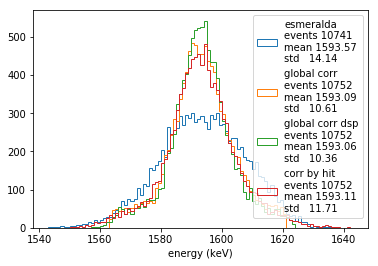

In [11]:
bins = 100
erange = (1600.-57., 1700.-57.) if type_peak is 'dspsel' else (2650.-57., 2780.-57.)
ut.hist(sdf.energy.values, bins, erange, fig = True , label = 'esmeralda');
ut.hist(sdf.ecln  .values, bins, erange, fig = False, label = 'global corr' );
ut.hist(sdf.ecdz  .values, bins, erange, fig = False, label = 'global corr dsp');
ut.hist(sdf.ecc   .values, bins, erange, fig = False, label = 'corr by hit');
plt.xlabel('energy (keV)');

energy resolution =   2.14 FWHM
energy resolution =   1.32 FWHM


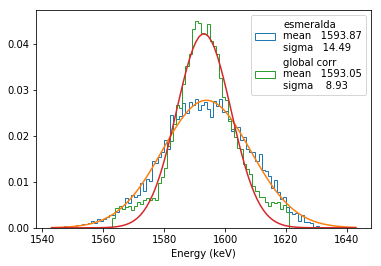

In [12]:
ut.plot_energy_resolution(sdf.energy.values, bins, erange, label = 'esmeralda');
ut.plot_energy_resolution(sdf.ecln  .values, bins, erange, label = 'global corr');
plt.xlabel('Energy (keV)');

energy resolution =   2.14 FWHM
energy resolution =   1.32 FWHM
energy resolution =   1.16 FWHM
energy resolution =   1.37 FWHM


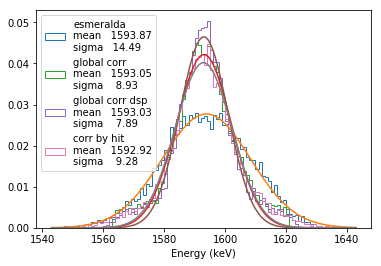

In [13]:
ut.plot_energy_resolution(sdf.energy.values, bins, erange, label = 'esmeralda');
ut.plot_energy_resolution(sdf.ecln  .values, bins, erange, label = 'global corr');
ut.plot_energy_resolution(sdf.ecdz  .values, bins, erange, label = 'global corr dsp' );
ut.plot_energy_resolution(sdf.ecc   .values, bins, erange, label = 'corr by hit');
plt.xlabel('Energy (keV)');

## Test - dependence with z

In [14]:
sel_bpos, pers = ut.sel_varzones(sdf.bpos, 4);

#for i, isel in enumerate(sel_bpos):
#    fig = True if i == 0 else False
#    ut.hist(sdf.bpos[isel], 100, fig = fig);
#plt.xlabel('position of blobs')
#ut.hist((sdf.fdzb1 - sdf.fdzb2) * sdf.dz, 100);
#ut.hist(sdf.blob1_z - sdf.blob2_z, 100, fig = True);
#plt.xlabel('distance between blobs')

In [15]:
def profile_zones(uvar, vvar, wvar, nzones = 5, norma = False, bins = 10, formate = '6.2f'):
    enor = np.mean(vvar)/100. if norma is True else 1.
    print(enor)
    sel_zones, pers = ut.sel_varzones(wvar, nzones);
    for i, isel in enumerate(sel_zones):
        fig = True if i == 0 else False
        ilabel = ('[ {0:' + formate+'}, {1:'+ formate+'}]').format(pers[i], pers[i+1])
        ut.hprofile(uvar[isel], vvar[isel] / enor, nbins_profile = bins, label = ilabel, fig = fig)
    plt.legend(); plt.grid();

15.947453322068549


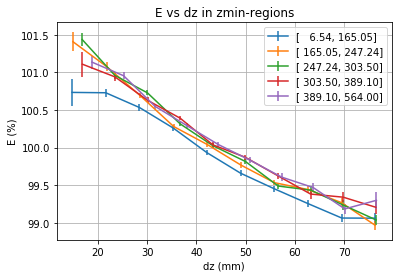

In [16]:
nzones, bins = 5, 10
ksel = sdf.dz < 80.
profile_zones(sdf.dz[ksel], sdf.energy[ksel], sdf.z_min[ksel], nzones = nzones, norma = True)
plt.xlabel('dz (mm)'); plt.ylabel('E (%)'); plt.title('E vs dz in zmin-regions');

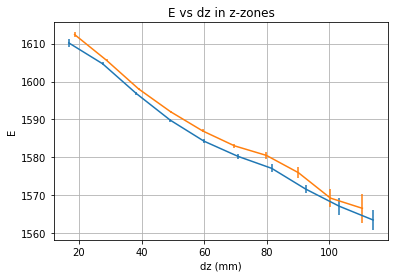

In [17]:
nzones, bins = 5, 10
ksel = sdf.z_max < 250
ut.hprofile(sdf.dz[ksel], sdf.energy[ksel], label = 'z_max < 250', fig = True)
ksel = sdf.z_min > 250
ut.hprofile(sdf.dz[ksel], sdf.energy[ksel], label = 'z_min > 250', fig = False)
plt.grid(); plt.xlabel('dz (mm)'); plt.ylabel('E'); plt.title('E vs dz in z-zones'); 

15.947453322068549


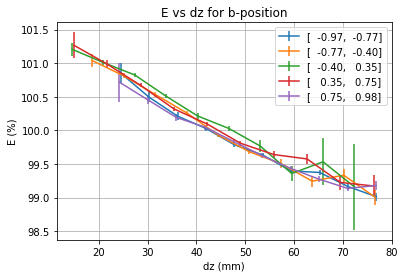

In [18]:
nzones, bins = 5, 10
ksel = sdf.dz < 80.
profile_zones(sdf.dz[ksel], sdf.energy[ksel], sdf.bpos[ksel], nzones = nzones, norma = True)
plt.xlabel('dz (mm)'); plt.ylabel('E (%)'); plt.title('E vs dz for b-position');

15.947453322068549


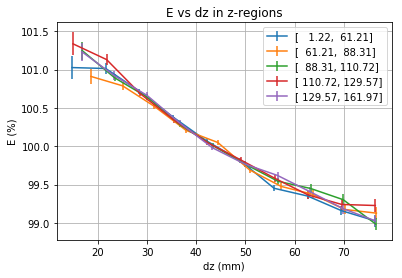

In [19]:
nzones, bins = 5, 10
ksel = sdf.dz < 80.
profile_zones(sdf.dz[ksel], sdf.energy[ksel], sdf.r_ave[ksel], nzones = nzones, norma = True)
plt.xlabel('dz (mm)'); plt.ylabel('E (%)'); plt.title('E vs dz in z-regions');

15.947453322068549


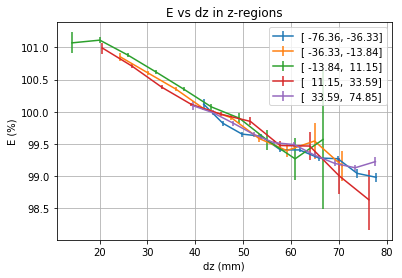

In [20]:
nzones, bins = 5, 10
ksel = sdf.dz < 80.
uvar = sdf.blob1_z - sdf.blob2_z
profile_zones(sdf.dz[ksel], sdf.energy[ksel], uvar[ksel], nzones = nzones, norma = True)
plt.xlabel('dz (mm)'); plt.ylabel('E (%)'); plt.title('E vs dz in z-regions');

In [21]:
### dependence with short tracks

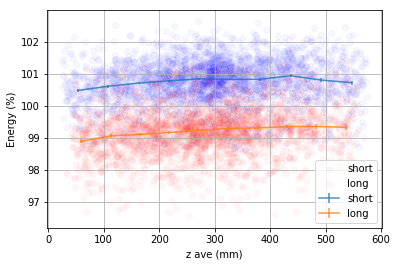

In [22]:
ksel = sel_short
enor = np.mean(sdf.energy)/100.
ut.hpscatter(sdf.z_ave[ksel], sdf.energy[ksel]/enor, alpha = 0.03, c = 'blue', label = 'short');
ksel = sel_long
ut.hpscatter(sdf.z_ave[ksel], sdf.energy[ksel]/enor, alpha = 0.03, c = 'red', fig = False, label = 'long');
plt.legend();
plt.xlabel('z ave (mm)'); plt.ylabel('Energy (%)'); plt.grid();

## Studies of slices

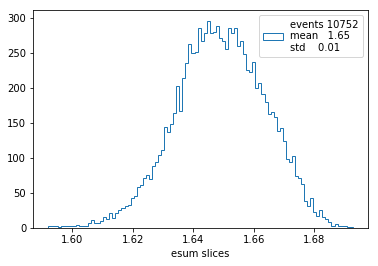

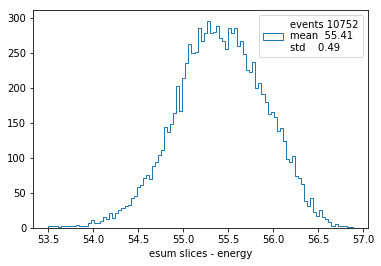

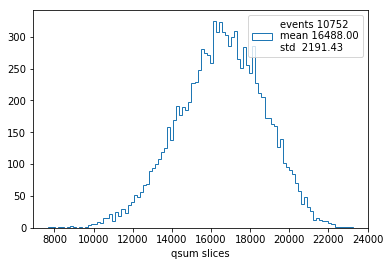

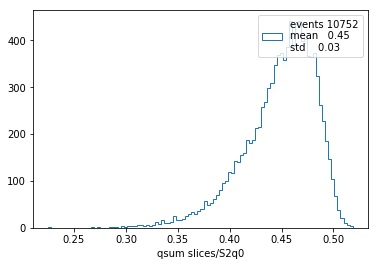

In [23]:
nslices = 5
etot = ut.slices_total(sdf, nslices)
ut.hist(etot, 100); plt.xlabel('esum slices')
ut.hist(1000.*etot - sdf.energy, 100);
plt.xlabel('esum slices - energy');
           
qtot = ut.slices_total(sdf, nslices, 'slcq')
ut.hist(qtot, 100)
plt.xlabel('qsum slices');
ut.hist(qtot/sdf.S2q0, 100);
plt.xlabel('qsum slices/S2q0');

### about Q and Q0

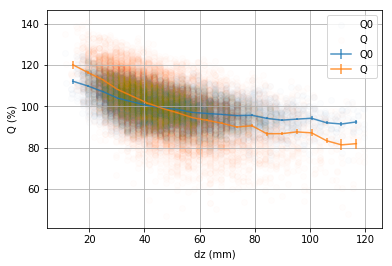

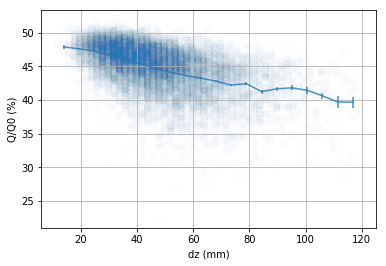

In [24]:
q0nor = np.mean(sdf.S2q0)/100.
ut.hpscatter(sdf.dz, sdf.S2q0/q0nor, nbins_profile = 20, alpha = 0.01, label = 'Q0'); 

qnorm = np.mean(qtot)/100.
ut.hpscatter(sdf.dz, qtot/qnorm, nbins_profile = 20, alpha = 0.01, label = 'Q', fig = False); 
plt.grid(); plt.ylabel('Q (%)'); plt.xlabel('dz (mm)');
plt.legend();

ut.hpscatter(sdf.dz, 100.*qtot/sdf.S2q0, nbins_profile = 20, alpha = 0.01, fig = True); 
plt.grid(); plt.ylabel('Q/Q0 (%)'); plt.xlabel('dz (mm)');
#plt.legend();

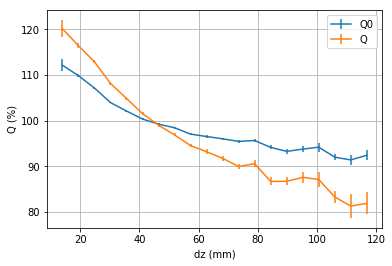

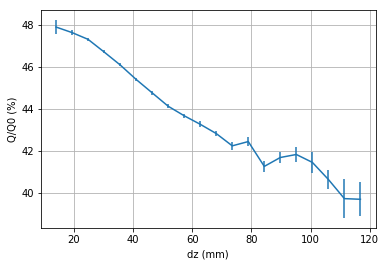

In [25]:
q0nor = np.mean(sdf.S2q0)/100.
ut.hprofile(sdf.dz, sdf.S2q0/q0nor, nbins_profile = 20, alpha = 1., label = 'Q0'); 

qnorm = np.mean(qtot)/100.
ut.hprofile(sdf.dz, qtot/qnorm, nbins_profile = 20, alpha = 1., label = 'Q', fig = False); 
plt.grid(); plt.ylabel('Q (%)'); plt.xlabel('dz (mm)');
plt.legend();

ut.hprofile(sdf.dz, 100.*qtot/sdf.S2q0, nbins_profile = 20, alpha = 1., fig = True); 
plt.grid(); plt.ylabel('Q/Q0 (%)'); plt.xlabel('dz (mm)');
#plt.legend();

### In the center region

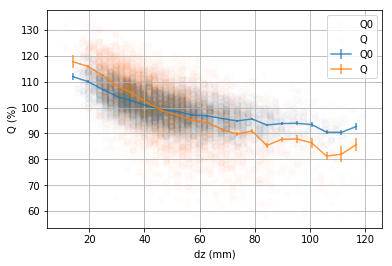

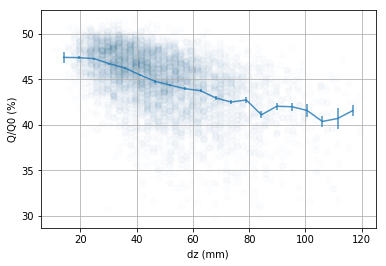

In [26]:
sel_center = sdf.r_ave < 100.
ksel       = sel_center
q0nor = np.mean(sdf.S2q0[ksel])/100.
ut.hpscatter(sdf.dz[ksel], sdf.S2q0[ksel]/q0nor, 
             nbins_profile = 20, alpha = 0.01, label = 'Q0'); 

qnorm = np.mean(qtot[sel_center])/100.
ut.hpscatter(sdf.dz[ksel], qtot[ksel]/qnorm, 
             nbins_profile = 20, alpha = 0.01, label = 'Q', fig = False); 
plt.grid(); plt.ylabel('Q (%)'); plt.xlabel('dz (mm)');
plt.legend();

ut.hpscatter(sdf.dz[ksel], 100.*qtot[ksel]/sdf.S2q0[ksel], nbins_profile = 20, alpha = 0.01, fig = True); 
plt.grid(); plt.ylabel('Q/Q0 (%)'); plt.xlabel('dz (mm)');
#plt.legend();

### E and Q

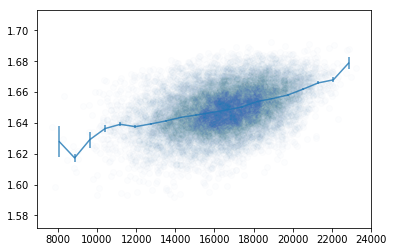

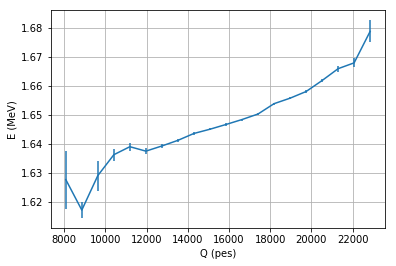

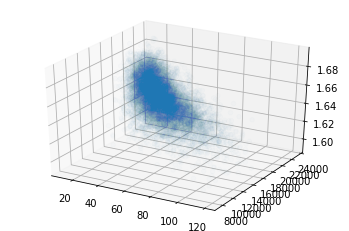

In [28]:
qq = ut.slices_total(sdf, nslices, 'slcq')
ut.hpscatter(qq, etot, nbins_profile = 20, alpha = 0.01);

ut.hprofile(qq, etot, nbins_profile = 20);
plt.grid(); plt.xlabel('Q (pes)'); plt.ylabel('E (MeV)');

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(sdf.dz, qq, etot, alpha = 0.01);

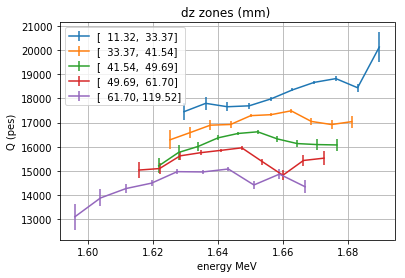

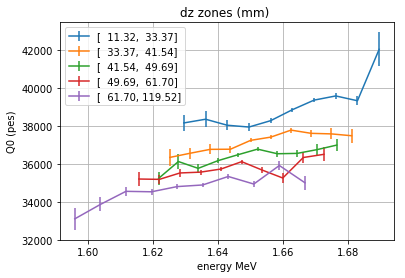

In [29]:
ut.hprofile_zones(etot, qq, sdf.dz, nzones = 5, norma = False, bins = 10, formate = '6.2f')
plt.xlabel('energy MeV'); plt.ylabel('Q (pes)'); plt.title('dz zones (mm) ');

ut.hprofile_zones(etot, sdf.S2q0, sdf.dz, nzones = 5, norma = False, bins = 10, formate = '6.2f')
plt.xlabel('energy MeV'); plt.ylabel('Q0 (pes)'); plt.title('dz zones (mm) ');

### About position of the dz tracks

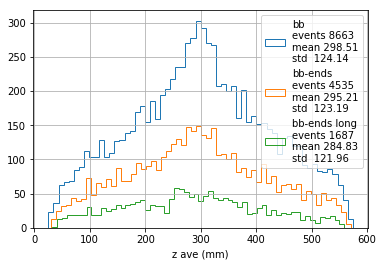

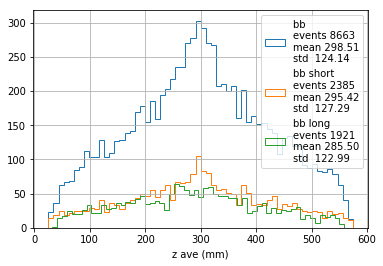

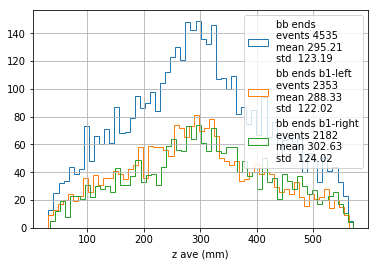

In [30]:
bins = 60
ut.hist(sdf.z_ave[sel_base], bins, label = 'bb');
ut.hist(sdf.z_ave[selB]    , bins, label = 'bb-ends'     , fig = False);
ut.hist(sdf.z_ave[selBlong], bins, label = 'bb-ends long', fig = False);
plt.grid(); plt.xlabel('z ave (mm)'); plt.legend();

ut.hist(sdf.z_ave[sel_base]            , bins, label = 'bb ');
ut.hist(sdf.z_ave[sel_base & sel_short], bins, label = 'bb short', fig = False);
ut.hist(sdf.z_ave[sel_base & sel_long ], bins, label = 'bb long' , fig = False);
plt.grid(); plt.xlabel('z ave (mm)'); plt.legend();

ut.hist(sdf.z_ave[selB] , bins, label = 'bb ends ');
ut.hist(sdf.z_ave[selBL], bins, label = 'bb ends b1-left', fig = False);
ut.hist(sdf.z_ave[selBR], bins, label = 'bb ends b1-right' , fig = False);
plt.grid(); plt.xlabel('z ave (mm)'); plt.legend();

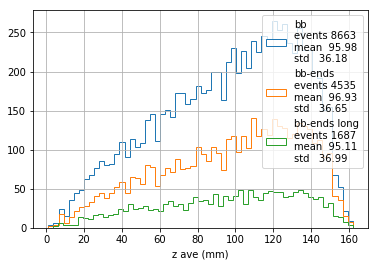

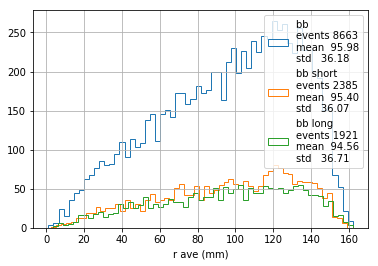

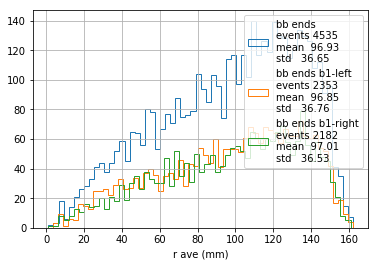

In [31]:
bins = 60
ut.hist(sdf.r_ave[sel_base], bins, label = 'bb');
ut.hist(sdf.r_ave[selB]    , bins, label = 'bb-ends'     , fig = False);
ut.hist(sdf.r_ave[selBlong], bins, label = 'bb-ends long', fig = False);
plt.grid(); plt.xlabel('z ave (mm)'); plt.legend();

ut.hist(sdf.r_ave[sel_base]            , bins, label = 'bb ');
ut.hist(sdf.r_ave[sel_base & sel_short], bins, label = 'bb short', fig = False);
ut.hist(sdf.r_ave[sel_base & sel_long ], bins, label = 'bb long' , fig = False);
plt.grid(); plt.xlabel('r ave (mm)'); plt.legend();

ut.hist(sdf.r_ave[selB] , bins, label = 'bb ends ');
ut.hist(sdf.r_ave[selBL], bins, label = 'bb ends b1-left', fig = False);
ut.hist(sdf.r_ave[selBR], bins, label = 'bb ends b1-right' , fig = False);
plt.grid(); plt.xlabel('r ave (mm)'); plt.legend();

## About the slices

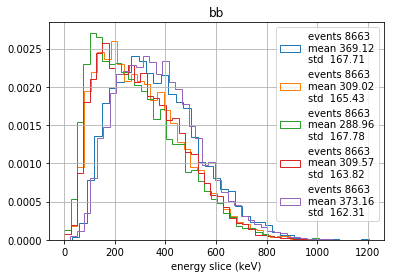

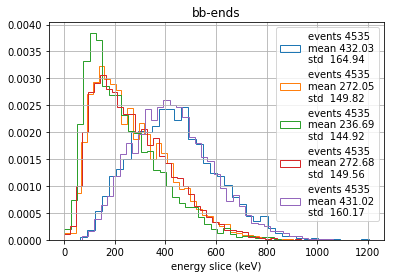

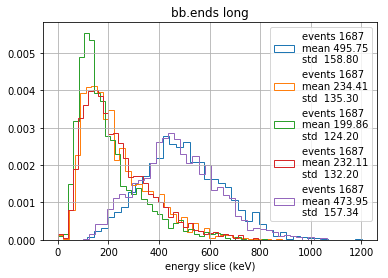

In [32]:
#ut.hist(sdf.slc40, 100, density = True);
ksel = sel_base
for i in range(nslices):
    ut.hist(1000.*sdf['slce'+str(i)][ksel], 40, fig = False, density = True);
plt.grid(); plt.xlabel('energy slice (keV)'); plt.title('bb')

ksel = selB
for i in range(nslices):
    fig = True if i == 0 else False
    ut.hist(1000.*sdf['slce'+str(i)][ksel], 40, fig = fig, density = True);
plt.grid(); plt.xlabel('energy slice (keV)'); plt.title('bb-ends')


ksel = selBlong
for i in range(nslices):
    fig = True if i == 0 else False
    ut.hist(1000.*sdf['slce'+str(i)][ksel], 40, fig = fig, density = True);
plt.grid(); plt.xlabel('energy slice (keV)'); plt.title('bb.ends long');


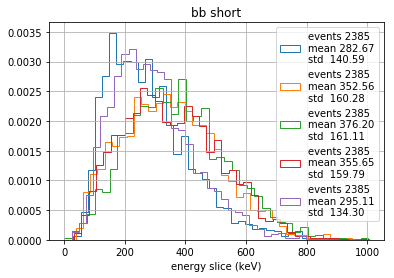

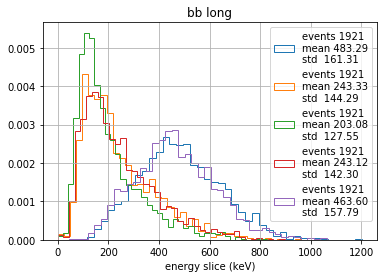

In [33]:
ksel = sel_base & sel_short
for i in range(nslices):
    fig = True if i == 0 else False
    ut.hist(1000.*sdf['slce'+str(i)][ksel], 40, fig = fig, density = True);
plt.grid(); plt.xlabel('energy slice (keV)'); plt.title('bb short')


ksel = sel_base & sel_long
for i in range(nslices):
    fig = True if i == 0 else False
    ut.hist(1000.*sdf['slce'+str(i)][ksel], 40, fig = fig, density = True);
plt.grid(); plt.xlabel('energy slice (keV)'); plt.title('bb long');


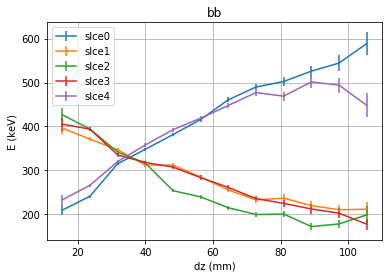

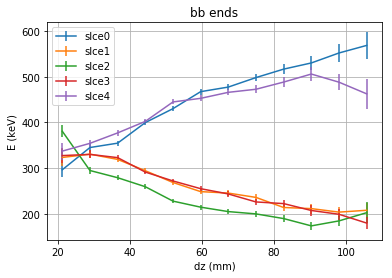

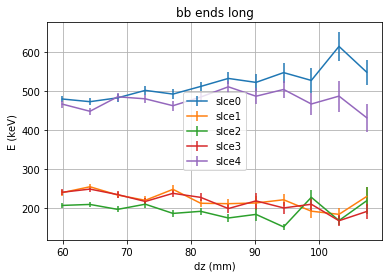

In [34]:
bins = 12
ksel = sel_base
ut.hprofile_slices(sdf[ksel], nslices, label = 'slce'  , bins = bins);
plt.title('bb');

bins = 12
ksel = selB
ut.hprofile_slices(sdf[ksel], nslices, label = 'slce'  , bins = bins);
plt.title('bb ends');

bins = 12
ksel = selBlong
ut.hprofile_slices(sdf[ksel], nslices, label = 'slce'  , bins = bins);
plt.title('bb ends long');

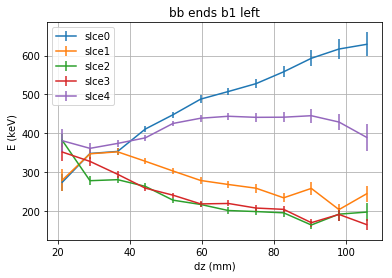

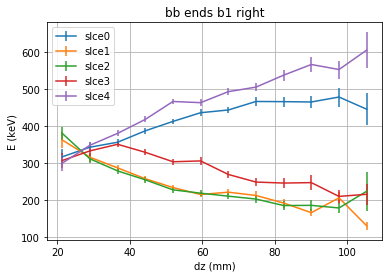

In [44]:
bins = 12
ksel = selBL
ut.hprofile_slices(sdf[ksel], nslices, label = 'slce'  , bins = bins);
plt.title('bb ends b1 left');

bins = 12
ksel = selBR
ut.hprofile_slices(sdf[ksel], nslices, label = 'slce'  , bins = bins);
plt.title('bb ends b1 right');

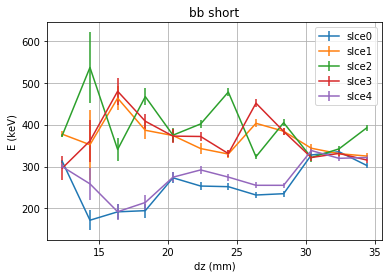

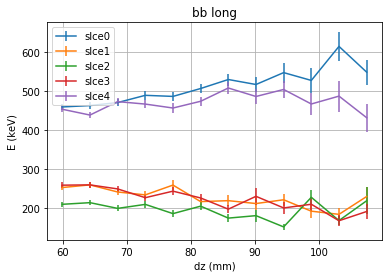

In [35]:
bins = 12
ksel = sel_base & sel_short
ut.hprofile_slices(sdf[ksel], nslices, label = 'slce'  , bins = bins);
plt.title('bb short');

bins = 12
ksel = sel_base & sel_long
ut.hprofile_slices(sdf[ksel], nslices, label = 'slce'  , bins = bins);
plt.title('bb long');

### slices vs z

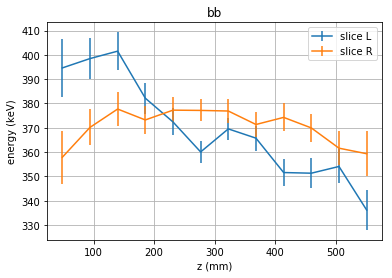

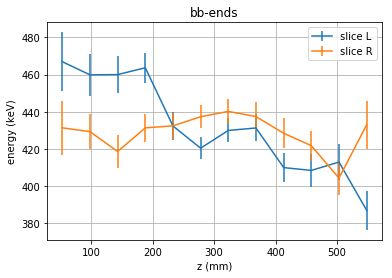

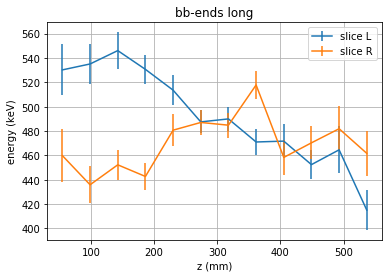

In [36]:
ksel = sel_base
ut.hprofile(sdf.z_ave[ksel], 1000.*sdf.slce0[ksel], nbins_profile = 12, label = 'slice L', fig = True);
ut.hprofile(sdf.z_ave[ksel], 1000.*sdf.slce4[ksel], nbins_profile = 12, label = 'slice R', fig = False);
plt.grid(); plt.xlabel('z (mm)'); plt.ylabel('energy (keV)'); plt.title('bb'); plt.legend();

ksel = selB
ut.hprofile(sdf.z_ave[ksel], 1000.*sdf.slce0[ksel], nbins_profile = 12, label = 'slice L', fig = True);
ut.hprofile(sdf.z_ave[ksel], 1000.*sdf.slce4[ksel], nbins_profile = 12, label = 'slice R', fig = False);
plt.grid(); plt.xlabel('z (mm)'); plt.ylabel('energy (keV)'); plt.title('bb-ends');  plt.legend();

ksel = selBlong
ut.hprofile(sdf.z_ave[ksel], 1000.*sdf.slce0[ksel], nbins_profile = 12, label = 'slice L', fig = True);
ut.hprofile(sdf.z_ave[ksel], 1000.*sdf.slce4[ksel], nbins_profile = 12, label = 'slice R', fig = False);
plt.grid(); plt.xlabel('z (mm)'); plt.ylabel('energy (keV)'); plt.title('bb-ends long'); plt.legend();

### slice most associated with B1 along dz and z

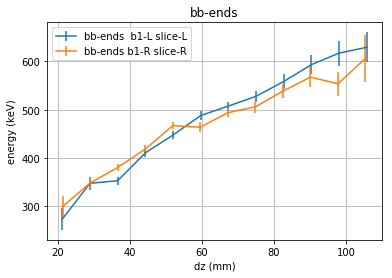

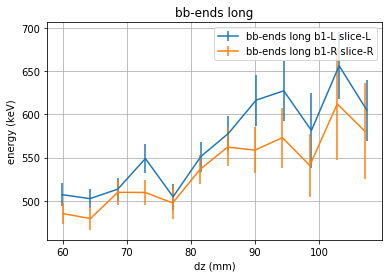

In [37]:
ksel = selBL
ut.hprofile(sdf.dz[ksel], 1000.*sdf.slce0[ksel], nbins_profile = 12, 
            label = 'bb-ends  b1-L slice-L', fig = True);
ksel = selBR
ut.hprofile(sdf.dz[ksel], 1000.*sdf.slce4[ksel], nbins_profile = 12, 
            label = 'bb-ends b1-R slice-R', fig = False);
plt.grid(); plt.xlabel('dz (mm)'); plt.ylabel('energy (keV)'); plt.title('bb-ends'); plt.legend();

ksel = selBLlong
ut.hprofile(sdf.dz[ksel], 1000.*sdf.slce0[ksel], nbins_profile = 12, 
            label = 'bb-ends long b1-L slice-L', fig = True);
ksel = selBRlong
ut.hprofile(sdf.dz[ksel], 1000.*sdf.slce4[ksel], nbins_profile = 12, 
            label = 'bb-ends long b1-R slice-R', fig = False);
plt.grid(); plt.xlabel('dz (mm)'); plt.ylabel('energy (keV)'); plt.title('bb-ends long'); plt.legend();

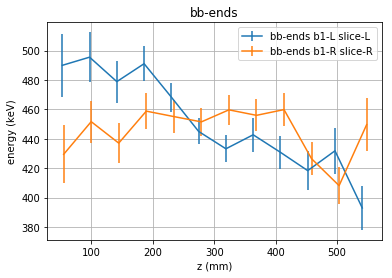

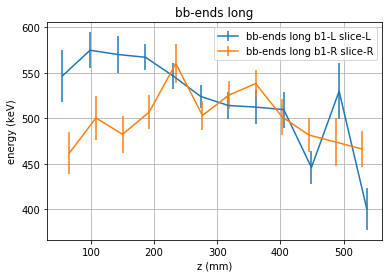

In [38]:
ksel = selBL
ut.hprofile(sdf.z_ave[ksel], 1000.*sdf.slce0[ksel], nbins_profile = 12, 
            label = 'bb-ends b1-L slice-L', fig = True);
ksel = selBR
ut.hprofile(sdf.z_ave[ksel], 1000.*sdf.slce4[ksel], nbins_profile = 12, 
            label = 'bb-ends b1-R slice-R', fig = False);
plt.grid(); plt.xlabel('z (mm)'); plt.ylabel('energy (keV)'); plt.title('bb-ends'); plt.legend();



ksel = selBLlong
ut.hprofile(sdf.z_ave[ksel], 1000.*sdf.slce0[ksel], nbins_profile = 12, 
            label = 'bb-ends long b1-L slice-L', fig = True);
ksel = selBRlong
ut.hprofile(sdf.z_ave[ksel], 1000.*sdf.slce4[ksel], nbins_profile = 12, 
            label = 'bb-ends long b1-R slice-R', fig = False);
plt.grid(); plt.xlabel('z (mm)'); plt.ylabel('energy (keV)'); plt.title('bb-ends long'); plt.legend();

### slice LR difference 

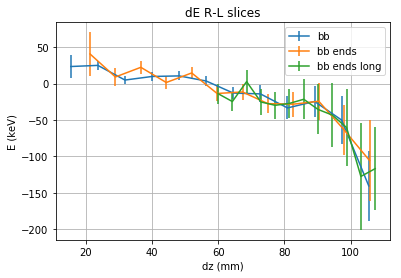

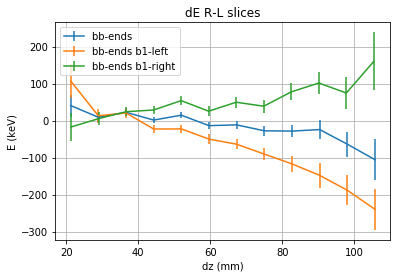

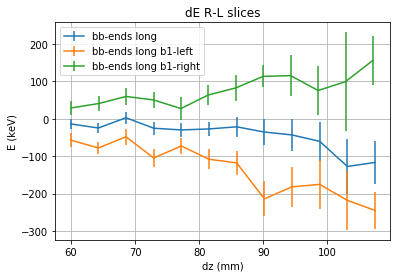

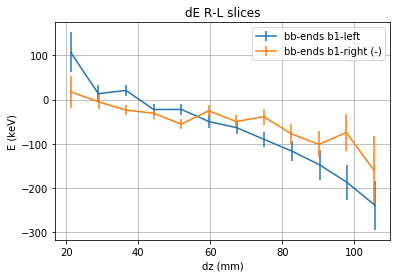

In [39]:
slc_lr = sdf.slce4 - sdf.slce0

ut.hprofile(sdf.dz[sel_base], 1000. * slc_lr[sel_base], nbins_profile = 12, label = 'bb', fig = False);
ut.hprofile(sdf.dz[selB    ], 1000. * slc_lr[selB]    , nbins_profile = 12, label = 'bb ends', fig = False);
ut.hprofile(sdf.dz[selBlong], 1000. * slc_lr[selBlong], nbins_profile = 12, label = 'bb ends long', fig = False);
plt.grid(); plt.xlabel('dz (mm)'); plt.ylabel('E (keV)'); plt.legend(); plt.title('dE R-L slices');

ut.hprofile(sdf.dz[selB] , 1000. * slc_lr[selB] , nbins_profile = 12, label = 'bb-ends '        , fig = True);
ut.hprofile(sdf.dz[selBL], 1000. * slc_lr[selBL], nbins_profile = 12, label = 'bb-ends b1-left' , fig = False);
ut.hprofile(sdf.dz[selBR], 1000. * slc_lr[selBR], nbins_profile = 12, label = 'bb-ends b1-right', fig = False);
plt.grid(); plt.xlabel('dz (mm)'); plt.ylabel('E (keV)'); plt.legend(); plt.title('dE R-L slices');

ut.hprofile(sdf.dz[selBlong] , 1000. * slc_lr[selBlong] , nbins_profile = 12, label = 'bb-ends long '        , fig = True);
ut.hprofile(sdf.dz[selBLlong], 1000. * slc_lr[selBLlong], nbins_profile = 12, label = 'bb-ends long b1-left' , fig = False);
ut.hprofile(sdf.dz[selBRlong], 1000. * slc_lr[selBRlong], nbins_profile = 12, label = 'bb-ends long b1-right', fig = False);
plt.grid(); plt.xlabel('dz (mm)'); plt.ylabel('E (keV)'); plt.legend(); plt.title('dE R-L slices');

ut.hprofile(sdf.dz[selBL],  1000. * slc_lr[selBL], nbins_profile = 12, label = 'bb-ends b1-left'     , fig = True);
ut.hprofile(sdf.dz[selBR], -1000. * slc_lr[selBR], nbins_profile = 12, label = 'bb-ends b1-right (-)', fig = False);
plt.grid(); plt.xlabel('dz (mm)'); plt.ylabel('E (keV)'); plt.legend(); plt.title('dE R-L slices');

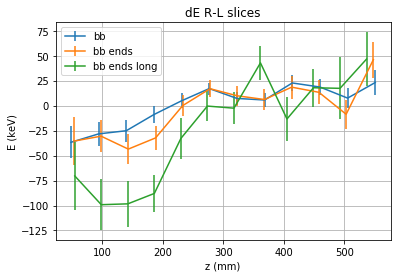

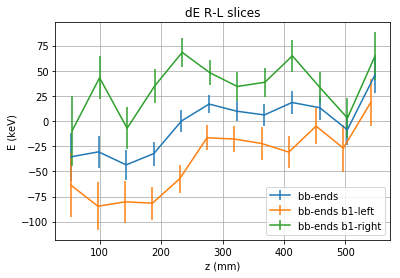

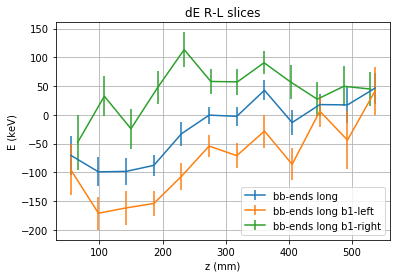

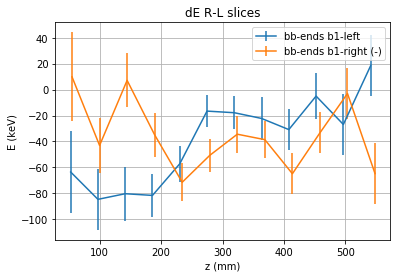

In [40]:
lc_lr = sdf.slce4 - sdf.slce0

ut.hprofile(sdf.z_ave[sel_base], 1000. * slc_lr[sel_base], nbins_profile = 12, label = 'bb', fig = False);
ut.hprofile(sdf.z_ave[selB    ], 1000. * slc_lr[selB]    , nbins_profile = 12, label = 'bb ends', fig = False);
ut.hprofile(sdf.z_ave[selBlong], 1000. * slc_lr[selBlong], nbins_profile = 12, label = 'bb ends long', fig = False);
plt.grid(); plt.xlabel('z (mm)'); plt.ylabel('E (keV)'); plt.legend(); plt.title('dE R-L slices');

ut.hprofile(sdf.z_ave[selB] , 1000. * slc_lr[selB] , nbins_profile = 12, label = 'bb-ends '        , fig = True);
ut.hprofile(sdf.z_ave[selBL], 1000. * slc_lr[selBL], nbins_profile = 12, label = 'bb-ends b1-left' , fig = False);
ut.hprofile(sdf.z_ave[selBR], 1000. * slc_lr[selBR], nbins_profile = 12, label = 'bb-ends b1-right', fig = False);
plt.grid(); plt.xlabel('z (mm)'); plt.ylabel('E (keV)'); plt.legend(); plt.title('dE R-L slices');

ut.hprofile(sdf.z_ave[selBlong] , 1000. * slc_lr[selBlong] , nbins_profile = 12, label = 'bb-ends long '        , fig = True);
ut.hprofile(sdf.z_ave[selBLlong], 1000. * slc_lr[selBLlong], nbins_profile = 12, label = 'bb-ends long b1-left' , fig = False);
ut.hprofile(sdf.z_ave[selBRlong], 1000. * slc_lr[selBRlong], nbins_profile = 12, label = 'bb-ends long b1-right', fig = False);
plt.grid(); plt.xlabel('z (mm)'); plt.ylabel('E (keV)'); plt.legend(); plt.title('dE R-L slices');

ut.hprofile(sdf.z_ave[selBL],  1000. * slc_lr[selBL], nbins_profile = 12, label = 'bb-ends b1-left'     , fig = True);
ut.hprofile(sdf.z_ave[selBR], -1000. * slc_lr[selBR], nbins_profile = 12, label = 'bb-ends b1-right (-)', fig = False);
plt.grid(); plt.xlabel('z (mm)'); plt.ylabel('E (keV)'); plt.legend(); plt.title('dE R-L slices');

## slices profile

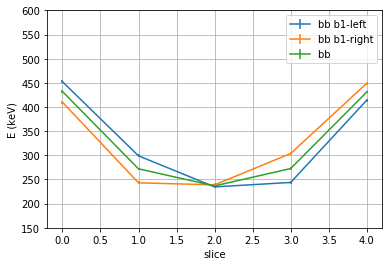

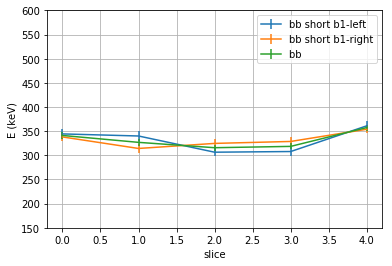

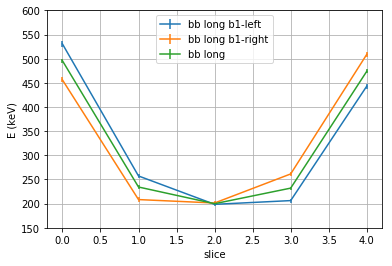

In [45]:
norma = False
ut.plt_slices(sdf[selBL], nslices, label = 'bb b1-left', norma = norma);
ut.plt_slices(sdf[selBR], nslices, label = 'bb b1-right', fig = False, norma = norma);
ut.plt_slices(sdf[selB] , nslices, label = 'bb  ', fig = False, norma = norma);
plt.xlabel('slice'); plt.ylabel('E (keV)'); plt.legend(); plt.grid();
plt.ylim(150., 600.);

norma = False
ut.plt_slices(sdf[selBL & sel_short], nslices, label = 'bb short b1-left', norma = norma);
ut.plt_slices(sdf[selBR & sel_short], nslices, label = 'bb short b1-right', fig = False, norma = norma);
ut.plt_slices(sdf[selB  & sel_short], nslices, label = 'bb  ', fig = False, norma = norma);
plt.xlabel('slice'); plt.ylabel('E (keV)'); plt.legend(); plt.grid();
plt.ylim(150., 600.);



ut.plt_slices(sdf[selBLlong], nslices, label = 'bb long b1-left', norma = norma);
ut.plt_slices(sdf[selBRlong], nslices, label = 'bb long b1-right', fig = False, norma = norma);
ut.plt_slices(sdf[selBlong] , nslices, label = 'bb long', fig = False, norma = norma);
#ut.plt_slices(sdf[selrl], nslices, label = '~bb  long', fig = False, norma = norma);
plt.xlabel('slice'); plt.ylabel('E (keV)'); plt.legend(); plt.grid();
plt.ylim(150., 600.);

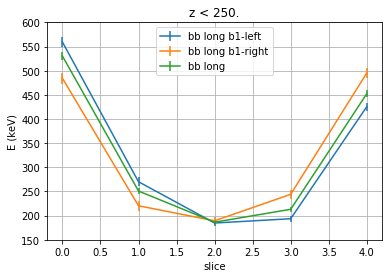

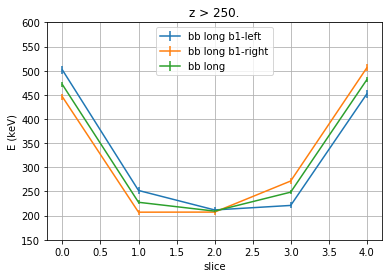

In [42]:
selz = sdf.z_max < 250.
ut.plt_slices(sdf[selBLlong & selz], nslices, label = 'bb long b1-left', norma = norma);
ut.plt_slices(sdf[selBRlong & selz], nslices, label = 'bb long b1-right', fig = False, norma = norma);
ut.plt_slices(sdf[selBlong  & selz] , nslices, label = 'bb long', fig = False, norma = norma);
#ut.plt_slices(sdf[selrl], nslices, label = '~bb  long', fig = False, norma = norma);
plt.xlabel('slice'); plt.ylabel('E (keV)'); plt.title('z < 250.'); plt.legend(); plt.grid();
plt.ylim(150., 600.);

selz = sdf.z_min > 250.
ut.plt_slices(sdf[selBLlong & selz], nslices, label = 'bb long b1-left', norma = norma);
ut.plt_slices(sdf[selBRlong & selz], nslices, label = 'bb long b1-right', fig = False, norma = norma);
ut.plt_slices(sdf[selBlong  & selz] , nslices, label = 'bb long', fig = False, norma = norma);
#ut.plt_slices(sdf[selrl], nslices, label = '~bb  long', fig = False, norma = norma);
plt.xlabel('slice'); plt.ylabel('E (keV)'); plt.title('z > 250.'); plt.legend(); plt.grid();
plt.ylim(150., 600.);

## Slices profiles 

In [ ]:
dz = 10
zs = np.arange(30., 120., dz);
for zi in zs[:-1]:
    ksel = (sdf.dz >= zi) & (sdf.dz < zi + dz)
    ilabel = '[' + str(zi) + ', ' +str(zi + dz) +')'
    ut.plt_slices(sdf[selBL & ksel], nslices, label = ilabel + ' BL ', fig = True);
    ut.plt_slices(sdf[selBR & ksel], nslices, label = ilabel + ' BR', fig = False);
    plt.legend(); plt.grid();

In [ ]:
#zs = np.arange(30., 120, dz)
_, zs = ut.sel_varzones(sdf.dz[selB], 10);
formate = '6.2f'

for i, zi in enumerate(zs[:-1]):
    ksel  =  (sdf.dz >= zs[i]) & (sdf.dz < zs[i + 1])
    ilabel = ('[{0:'+formate + '}, {1:' +formate+'})').format(zs[i], zs[i+1])
    ut.plt_slices(sdf[selBL & ksel], nslices, label = ilabel + ' BL ', fig = True);
    ut.plt_slices(sdf[selBR & ksel], nslices, label = ilabel + ' BR', fig = False);
    plt.grid(); plt.legend();

In [ ]:
#zs = np.arange(30., 120, dz)
_, zs = ut.sel_varzones(sdf.dz[selB], 10);
formate = '6.2f'

for i, zi in enumerate(zs[:-1]):
    ksel  =  (sdf.dz >= zs[i]) & (sdf.dz < zs[i + 1]) & (sdf.z_max < 250)
    ilabel = ('[{0:'+formate + '}, {1:' +formate+'})').format(zs[i], zs[i+1])
    ut.plt_slices(sdf[selBL & ksel], nslices, label = ilabel + ' BL ', fig = True);
    ut.plt_slices(sdf[selBR & ksel], nslices, label = ilabel + ' BR', fig = False);
    plt.grid(); plt.title('z max < 250'); plt.legend();
    
    ksel  =  (sdf.dz >= zs[i]) & (sdf.dz < zs[i + 1]) & (sdf.z_min > 250)
    ilabel = ('[{0:'+formate + '}, {1:' +formate+'})').format(zs[i], zs[i+1])
    ut.plt_slices(sdf[selBL & ksel], nslices, label = ilabel + ' BL ', fig = True);
    ut.plt_slices(sdf[selBR & ksel], nslices, label = ilabel + ' BR', fig = False);
    plt.grid(); plt.title('z min > 250'); plt.legend();
    
    
    

### About blobs

In [ ]:
sell, selr = selBL, selBR

ut.hprofile(sdf.dz[sell], 1000.* sdf.eblob1[sell], label = 'B1 BL', fig = True);
ut.hprofile(sdf.dz[sell], 1000.* sdf.eblob2[sell], label = 'B2 BL', fig = False);
ut.hprofile(sdf.dz[selr], 1000.* sdf.eblob1[selr], label = 'B1 BR', fig = False);
ut.hprofile(sdf.dz[selr], 1000.* sdf.eblob2[selr], label = 'B2 BR', fig = False);
plt.grid(); plt.legend(); plt.xlabel('dz (mm)'); plt.ylabel('energy (keV)'); plt.title('eblob')

ut.hprofile(sdf.dz[sell], 1000.* sdf.slcb1e[sell], label = 'B1 BL', fig = True);
ut.hprofile(sdf.dz[sell], 1000.* sdf.slcb2e[sell], label = 'B2 BL', fig = False);
ut.hprofile(sdf.dz[selr], 1000.* sdf.slcb1e[selr], label = 'B1 BR', fig = False);
ut.hprofile(sdf.dz[selr], 1000.* sdf.slcb2e[selr], label = 'B2 BR', fig = False);
plt.grid(); plt.legend(); plt.xlabel('dz (mm)'); plt.ylabel('energy (keV)'); plt.title('slice blob')

sleft  = sdf.slce0 #+ sdf.slce1 + sdf.slce2
sright = sdf.slce4 #+ sdf.slce8 + sdf.slce7

ut.hprofile(sdf.dz[sell], 1000.* sleft [sell], label = 'B1 BL', fig = True);
ut.hprofile(sdf.dz[sell], 1000.* sright[sell], label = 'B2 BL', fig = False);
ut.hprofile(sdf.dz[selr], 1000.* sright[selr], label = 'B1 BR', fig = False);
ut.hprofile(sdf.dz[selr], 1000.* sleft [selr], label = 'B2 BR', fig = False);
plt.grid(); plt.legend(); plt.xlabel('dz (mm)'); plt.ylabel('energy (keV)'); plt.title('slice LR');


In [ ]:
sell, selr = selBL, selBR

ut.hprofile(sdf.blob1_z[sell], 1000.* sdf.eblob1[sell], label = 'B1 BL', fig = True);
ut.hprofile(sdf.blob2_z[sell], 1000.* sdf.eblob2[sell], label = 'B2 BL', fig = False);
ut.hprofile(sdf.blob1_z[selr], 1000.* sdf.eblob1[selr], label = 'B1 BR', fig = False);
ut.hprofile(sdf.blob2_z[selr], 1000.* sdf.eblob2[selr], label = 'B2 BR', fig = False);
plt.grid(); plt.legend(); plt.xlabel('z (mm)'); plt.ylabel('energy (keV)'); plt.title('eblob')


#sell, selr = selBLlong, selBRlong
ut.hprofile(sdf.slcb1z[sell], 1000.* sdf.slcb1e[sell], label = 'B1 long BL', fig = True);
ut.hprofile(sdf.slcb2z[sell], 1000.* sdf.slcb2e[sell], label = 'B2 long BL', fig = False);
ut.hprofile(sdf.slcb1z[selr], 1000.* sdf.slcb1e[selr], label = 'B1 long BR', fig = False);
ut.hprofile(sdf.slcb2z[selr], 1000.* sdf.slcb2e[selr], label = 'B2 long BR', fig = False);
plt.grid(); plt.legend(); plt.xlabel('z (mm)'); plt.ylabel('energy (keV)'); plt.title('slice blob')


sleft  = sdf.slce0 #+ sdf.slce1 + sdf.slce2
sright = sdf.slce4 #+ sdf.slce8 + sdf.slce7

ut.hprofile(sdf.z_min[sell], 1000.* sleft [sell], label = 'B1 long BL', fig = True);
ut.hprofile(sdf.z_max[sell], 1000.* sright[sell], label = 'B2 long BL', fig = False);
ut.hprofile(sdf.z_max[selr], 1000.* sright[selr], label = 'B1 long BR', fig = False);
ut.hprofile(sdf.z_min[selr], 1000.* sleft [selr], label = 'B2 long BR', fig = False);
plt.grid(); plt.legend(); plt.xlabel('z (mm)'); plt.ylabel('energy (keV)'); plt.title('slice LR');

In [ ]:
sell, selr = selBL, selBR

ut.hprofile(sdf.dz[sell], 1000.*(sdf.eblob1[sell] - sdf.eblob2[sell]), label = 'B1 BL', fig = True);
ut.hprofile(sdf.dz[selr], 1000.*(sdf.eblob1[selr] - sdf.eblob2[selr]), label = 'B1 BR', fig = False);
plt.grid(); plt.legend(); plt.xlabel('dz (mm)'); plt.ylabel('energy (keV)'), plt.title('dE blobs')


ut.hprofile(sdf.dz[sell], 1000.*(sdf.slcb1e[sell] - sdf.slcb2e[sell]), label = 'B1 BL', fig = True);
ut.hprofile(sdf.dz[selr], 1000.*(sdf.slcb1e[selr] - sdf.slcb2e[selr]), label = 'B1 BR', fig = False);
plt.grid(); plt.legend(); plt.xlabel('dz (mm)'); plt.ylabel('energy (keV)'), plt.title('dE slice blobs')

ut.hprofile(sdf.dz[sell], 1000.*(-sright[sell] + sleft[sell]), label = 'B1 BL', fig = True);
ut.hprofile(sdf.dz[selr], 1000.*( sright[selr] - sleft[selr]), label = 'B1 BR', fig = False);
plt.grid(); plt.legend(); plt.xlabel('dz (mm)'); plt.ylabel('energy (keV)'), plt.title('dE slice LR');


### Fit the eblob vs z dependence

In [ ]:
pars, cov = ut.plt_hlinefit(sdf.blob1_z[selB], sdf.eblob1[selB], bins = 20)
plt.xlabel('z (mm)'); plt.ylabel('energy (keV)'); plt.title('blob1')
print('eblob1 vs zblob1 ', pars, pars[0]/pars[1])

pars, cov = ut.plt_hlinefit(sdf.blob2_z[selB], 1000.*sdf.eblob2[selB], bins = 20)
plt.xlabel('z (mm)'); plt.ylabel('energy (keV)'); plt.title('blob2')
print('eblob2 vs zblob2 ', pars, pars[0]/pars[1])

pars, cov = ut.plt_hlinefit(sdf.dz[selB], 1000.*sdf.eblob1[selB], bins = 20)
plt.xlabel('dz (mm)'); plt.ylabel('energy (keV)'); plt.title('blob1')
print('eblob1 vs dz     ', pars, pars[0]/pars[1])

pars, cov = ut.plt_hlinefit(sdf.dz[selB], 1000.*sdf.eblob2[selB], bins = 20)
plt.xlabel('dz (mm)'); plt.ylabel('energy (keV)'); plt.title('blob2')
print('eblob2 vs dz     ', pars, pars[0]/pars[1])

pars, cov = ut.plt_hlinefit(sdf.dz[selB], sdf.energy[selB], bins = 20)
plt.xlabel('dz (mm)'); plt.ylabel('energy (keV)'); plt.title('energy')
print('energy vs dz     ', pars, pars[0]/pars[1])

In [ ]:
def _lncor(e, z, alpha = 0., b0 = 1.):
    ## e in MeV, z in mm
    ec =   e * (1. - (alpha/b0) * z)
    return ec

a, b = -1.2e-4, 0.401
ecs   = [_lncor(sdf['slce'+str(i)].values, sdf['slcz'+str(i)].values, a, b) for i in range(nslices)]

ectot = ecs[0] + ecs[1] + ecs[2] + ecs[3] + ecs[4]

a, b = -0.43e-3, 1.613
zs = np.linspace(0., 550., 10)
plt.plot(zs, _lncor(1., zs, a, b));
a, b = -1.2e-4, 1.
plt.plot(zs, _lncor(1., zs, a, b));


#a, b = -0.43e-3, 1.613
a, b = -1.24e-4, 0.401 
print(a/b)
a, b = -0.43e-3, 1.613
print(a/b)
ut.hist(_lncor(sdf.energy, sdf.dz   , a, b), 100);
ut.hist(_lncor(sdf.energy, sdf.z_ave, a, b), 100);

a, b = -1.24e-4, 0.401 
ut.hist(_lncor(sdf.eblob1, sdf.dz     , a, b), 100);
ut.hist(_lncor(sdf.eblob1, sdf.blob1_z, a, b), 100);


#a, b = -0.43e-4, 1.613
#ut.hist(_lncor(sdf.energy, sdf.dz, a, b), 100);


# eblob1c = _ecor(sdf.eblob1.values, sdf.blob1_z.values);
#ut.hist(eblob1c, 100);
#ut.hist(sdf.eblob1, 100, fig = False);
#ut.hprofile(sdf.blob1_z[selB], eblob1c[selB], alpha = 1.0);
#ut.hprofile(sdf.blob1_z[selB], sdf.eblob1[selB], alpha = 1.0, fig = False);

In [ ]:
#np.mean(ectot)
ut.hist(ectot[selB], 100);
ut.hprofile(sdf.dz[selB], ectot[selB])

### slices vs z

In [ ]:
bins = 12
ksel = sel_base
ut.hprofile_slices(sdf[ksel], nslices, label = 'slce'  , bins = bins);
plt.title('bb');

bins = 12
ksel = selB
ut.hprofile_slices(sdf[ksel], nslices, label = 'slce'  , bins = bins);
plt.title('bb ends');

bins = 12
ksel = selBlong
ut.hprofile_slices(sdf[ksel], nslices, label = 'slce'  , bins = bins);
plt.title('bb ends long');

In [ ]:
nzones = 4
ksel = sdf.dz > 20.
profile_zones(sdf.dz[ksel], 50. * sdf.slc40a[ksel], sdf.bpos[ksel], norma = False, nzones = nzones)
print(ut.sstats(50.*sdf.slc40a[ksel])); plt.grid();

In [ ]:
f = 1000.
ksel = (sdf.dz > 20.) & (abs(sdf.bpos) > 0.70) & (sdf.eblob2 > 0.160) & (sdf.dz < 100.)
#ksel = ksel & (sdf.z_ave >= 100.) & (sdf.z_ave < 600.)
ksel = ksel & (sdf.dz    >= 60)   & (sdf.dz    < 70.)
ut.hist(f*sdf.slce0[ksel], 60);
#ut.hist(f*sdf.slce1, 100, fig = False);
#ut.hist(f*sdf.slce2, 100, fig = False);
#ut.hist(f*sdf.slce3, 100, fig = False);
ut.hist(f * sdf.slce9[ksel], 60, fig = False);
ut.hist(f *(sdf.slce4[ksel] - sdf.slce0[ksel]), 100);
ut.hist(f *(sdf.slce3[ksel] - sdf.slce1[ksel]), 100);

In [ ]:
isels, ipers= ut.sel_varzones(sdf.bpos, 5);
ut.hist(sdf.z_ave[isels[0]] , 60);
ut.hist(sdf.z_ave[isels[-1]], 60, fig = False);
ut.hprofile(sdf.z_ave, 1000.*(sdf.slce9 - sdf.slce0));
plt.grid();
ut.hprofile(sdf.z_ave, sdf.dz);
plt.grid();

In [ ]:
nzones = 4
ksel = (sdf.dz > 20.) & (abs(sdf.bpos) > 0.70) & (sdf.eblob2 > 0.160) & (sdf.dz < 100.) 
ksel = ksel & (sdf.z_min > 000.) & (sdf.z_max < 600.)
vvar = sdf.slc40a
#vvar = (sdf.slce4.values - sdf.slce0.values) / sdf.slce0.values
#vvar =  sdf.slc40
#vvar = abs(sdf.bpos) > 0.79
profile_zones(sdf.dz[ksel], vvar[ksel], sdf.bpos[ksel], norma = False, nzones = nzones)
#plt.ylim(0., 300.)
profile_zones(sdf.dz[ksel], vvar[ksel], sdf.z_ave[ksel], norma = False, nzones = nzones)
#plt.ylim(0., 300.)

print(ut.sstats(50.*sdf.slc40a[ksel])); 

In [ ]:
ksel = abs(sdf.bpos) > 0.7
hfun = ut.hprofile
hfun(sdf.dz[ksel], 1000. * sdf.slce0[ksel], alpha = 1., label = '0');
hfun(sdf.dz[ksel], 1000. * sdf.slce9[ksel], alpha = 1., fig = False, label = '9');
plt.legend();

In [ ]:
nslices, bins  = 10, 10
ksel = sdf.dz > 0.
ksel = (sdf.dz > 20.) & (abs(sdf.bpos) > 0.0) & (sdf.eblob2 > 0.160) & (sdf.dz < 100.)
ut.hprofile_slices(sdf[ksel], nslices, label = 'slce'  , bins = bins);
#ut.hprofile_slices(sdf, nslices, label = 'slcec' , bins = bins);
ut.hprofile_slices(sdf[ksel], nslices, label = 'slcq'  , bins = bins, factor = 1./22.);
plt.ylabel('Q (a.u)');

In [ ]:
ut.hprofile_slices(sdf[sela], nslices, 'slce', bins = 10);
plt.title('b1b2'); plt.ylim(0., 500.);
ut.hprofile_slices(sdf[selb], nslices, 'slce', bins = 10);
plt.title('b2b1'); plt.ylim(0., 500.);
ut.hprofile_slices(sdf[selc], nslices, 'slce', bins = 10);
plt.title('bb'); plt.ylim(0., 500.);
ut.hprofile_slices(sdf[selr], nslices, 'slce', bins = 10);
plt.title('~bb'); plt.ylim(0., 500.);

In [ ]:
norma = False
ut.plt_slices(sdf[sela], nslices, label = 'b1b2', norma = norma);
ut.plt_slices(sdf[selb], nslices, label = 'b2b1', fig = False, norma = norma);
ut.plt_slices(sdf[selc], nslices, label = 'bb  ', fig = False, norma = norma);
ut.plt_slices(sdf[selr], nslices, label = '~bb ', fig = False, norma = norma);
plt.xlabel('slice'); plt.ylabel('E (keV)'); plt.legend(); plt.grid();
plt.ylim(100., 300.);

ut.plt_slices(sdf[selal], nslices, label = 'b1b2 long', norma = norma);
ut.plt_slices(sdf[selbl], nslices, label = 'b2b1 long', fig = False, norma = norma);
ut.plt_slices(sdf[selcl], nslices, label = 'bb   long', fig = False, norma = norma);
#ut.plt_slices(sdf[selrl], nslices, label = '~bb  long', fig = False, norma = norma);
plt.xlabel('slice'); plt.ylabel('E (keV)'); plt.legend(); plt.grid();
plt.ylim( 50., 350.);

In [ ]:
nzones = 2
ksel = (sdf.dz > 20.) & (abs(sdf.bpos) > 0.7) & (sdf.eblob2 > 0.160) & (sdf.dz < 100.)
vvar = sdf.slc40n
#vvar =  sdf.slc40
#vvar = abs(sdf.bpos) > 0.79
profile_zones(sdf.dz[ksel], vvar[ksel], sdf.bpos[ksel], norma = False, nzones = nzones)
#print(ut.sstats(sdf.slc40[ksel])); 

In [ ]:
zs =  np.arange(30., 100, 10.)
print(zs)
for zi in zs:
    z0, dz, bpos = zi, 10., 0.75
    ksel = (sdf.dz >= z0) & (sdf.dz <= z0 + dz) & (abs(sdf.bpos) >= bpos) & (sdf.eblob2 > 0.160)
    xdf1 = ut.dfslices(sdf[ksel], 5);
    enor = 1e-3/nslices
    ilabel = '[' + str(z0) + ', ' +str(z0 + dz) +')'
    #ut.hpscatter(xdf1.dz, xdf1.ec/enor, nbins_profile = 5, alpha = 0.2, label = ilabel, c = 'grey');
    ut.hprofile (xdf1.dz, xdf1.ec, nbins_profile = 10, alpha = 0.8, label = ilabel, fig = False);
    plt.xlabel('dz (mm)'); plt.ylabel('E (keV)'); plt.grid(); plt.legend();
#ksel = (sdf.dz >= 70) & (sdf.dz <= 75.) & (sdf.bpos >  0.75)
#xdf2 = ut.dfslices(sdf[ksel], 5);

In [ ]:
zs =  np.arange(30., 100, 10.)
print(zs)
for zi in zs:
    z0, dz, bpos = zi, 10., 0.75
    ksel = (sdf.dz >= z0) & (sdf.dz <= z0 + dz) & (abs(sdf.bpos) >= bpos) & selc
    xdf1 = ut.dfslices(sdf[ksel], 5);
    enor = 1e-3/nslices
    ilabel = '[' + str(z0) + ', ' +str(z0 + dz) +')'
    #ut.hpscatter(xdf1.dz, xdf1.ec/enor, nbins_profile = 5, alpha = 0.2, label = ilabel, c = 'grey');
    ut.hprofile (xdf1.i, xdf1.ec/enor, nbins_profile = 100, alpha = 0.8, label = ilabel, fig = False);
    plt.xlabel('slice'); plt.ylabel('E (keV)'); plt.grid(); plt.legend();
#ksel = (sdf.dz >= 70) & (sdf.dz <= 75.) & (sdf.bpos >  0.75)
#xdf2 = ut.dfslices(sdf[ksel], 5);

In [ ]:
zs =  np.arange(30., 110, 10.)
print(zs)
for zi in zs:
    z0, dz, bpos = zi, 10., 0.75
    ksel = (sdf.dz >= z0) & (sdf.dz <= z0 + dz) & (abs(sdf.bpos) >= 0.70) & (sdf.eblob2 > 0.160)
    ilabel = '[' + str(z0) + ', ' +str(z0 + dz) +')'
    #ut.hpscatter(xdf1.dz, xdf1.ec/enor, nbins_profile = 5, alpha = 0.2, label = ilabel, c = 'grey');
    ut.plt_slices(sdf[ksel], nslices, label = ilabel, fig = False);
plt.legend(); plt.grid();
#    plt.xlabel('slice'); plt.ylabel('E (keV)'); plt.grid(); plt.legend();
#ksel = (sdf.dz >= 70) & (sdf.dz <= 75.) & (sdf.bpos >  0.75)
#xdf2 = ut.dfslices(sdf[ksel], 5);

In [ ]:
ksel = (abs(sdf.bpos) >= 0.70) & (sdf.eblob2 > 0.160) & (sdf.dz < 120.)
ut.hprofile(sdf.dz[ksel],   50.*sdf.slc40a[ksel], nbins_profile = 8);
plt.grid();
ut.hprofile(sdf.dz[ksel], sdf.slc40n[ksel], nbins_profile = 8);
plt.grid();

In [ ]:
selBL = (abs(sdf.bpos) >= 0.70) & (sdf.eblob2 > 0.160) & (sdf.dz > 20.) & (sdf.dz < 110.) & (sdf.bpos <= -0.7) 
selBR = (abs(sdf.bpos) >= 0.70) & (sdf.eblob2 > 0.160) & (sdf.dz > 20.) & (sdf.dz < 110.) & (sdf.bpos >=  0.7) 

In [ ]:
ut.hprofile(sdf.dz[selBL], sdf.slce0[selBL], nbins_profile = 10);
ut.hprofile(sdf.dz[selBR], sdf.slce4[selBR], nbins_profile = 10, fig = False);
plt.grid();

ut.hprofile(sdf.dz[selBL], sdf.slce4[selBL], nbins_profile = 10);
ut.hprofile(sdf.dz[selBR], sdf.slce0[selBR], nbins_profile = 10, fig = False);
plt.grid();

dz = 10
zs = np.arange(30., 120., dz);
for zi in zs:
    ksel = (sdf.dz >= zi) & (sdf.dz < zi + dz)
    ilabel = '[' + str(zi) + ', ' +str(zi + dz) +')'
    ut.plt_slices(sdf[selBL & ksel], nslices, label = ilabel + 'BL ', fig = True);
    ut.plt_slices(sdf[selBR & ksel], nslices, label = ilabel + 'BR', fig = False);
    plt.legend(); plt.grid();

In [ ]:
ut.hprofile(sdf.dz[selBL], sdf.slcb1e[selBL], nbins_profile = 10);
ut.hprofile(sdf.dz[selBR], sdf.slcb1e[selBR], nbins_profile = 10, fig = False);
plt.grid();

ut.hprofile(sdf.dz[selBL], sdf.slcb2e[selBL], nbins_profile = 10);
ut.hprofile(sdf.dz[selBR], sdf.slcb2e[selBR], nbins_profile = 10, fig = False);
plt.grid();

In [ ]:
ut.hprofile(sdf.z_ave[selBL], sdf.slce0[selBL] + , nbins_profile = 10);
ut.hprofile(sdf.z_ave[selBR], sdf.slce9[selBR], nbins_profile = 10, fig = False);

ut.hprofile(sdf.z_ave[selBL], sdf.slce4[selBL], nbins_profile = 10);
ut.hprofile(sdf.z_ave[selBR], sdf.slce9[selBR], nbins_profile = 10, fig = False);

In [ ]:
ut.hist(1000.*sdf.slce0[selBL], 100, fig = False);
ut.hist(1000.*sdf.slce9[selBR], 100, fig = False);

In [ ]:
ut.hprofile(sdf.dz[selBL], 1000.*sdf.slce0[selBL], fig = False);
ut.hprofile(sdf.dz[selBR], 1000.*sdf.slce9[selBR], fig = False);

ut.hprofile(sdf.dz[selBL], 1000.*sdf.slce9[selBL], fig = False);
ut.hprofile(sdf.dz[selBR], 1000.*sdf.slce0[selBR], fig = False);


#ut.hprofile(sdf.dz[ksel], 50.*sdf.slc40a[ksel], fig = True);
plt.grid();

In [ ]:
ff = np.ones(len(sdf))
#ff =  1./(1 - 2.76e-4*sdf.dz)
ut.hprofile(sdf.dz[selBL], 1000.* ff[selBL] * sdf.eblob1[selBL], label = 'B1 BL', fig = True);
ut.hprofile(sdf.dz[selBL], 1000.* ff[selBL] * sdf.eblob2[selBL], label = 'B2 BL', fig = False);
ut.hprofile(sdf.dz[selBR], 1000.* ff[selBR] * sdf.eblob1[selBR], label = 'B1 BR', fig = False);
ut.hprofile(sdf.dz[selBR], 1000.* ff[selBR] * sdf.eblob2[selBR], label = 'B2 BR', fig = False);
#ut.hprofile(sdf.dz[ksel],  sdf.slcb1[ksel], fig = True);
plt.grid(); plt.legend();

#ff =  1./(1 - 2.76e-4*sdf.dz)
ut.hprofile(sdf.dz[selBL], 1000.* ff[selBL] * sdf.slcb1e[selBL], label = 'B1 BL', fig = True);
ut.hprofile(sdf.dz[selBL], 1000.* ff[selBL] * sdf.slcb2e[selBL], label = 'B2 BL', fig = False);
ut.hprofile(sdf.dz[selBR], 1000.* ff[selBR] * sdf.slcb1e[selBR], label = 'B1 BR', fig = False);
ut.hprofile(sdf.dz[selBR], 1000.* ff[selBR] * sdf.slcb2e[selBR], label = 'B2 BR', fig = False);
#ut.hprofile(sdf.dz[ksel],  sdf.slcb1[ksel], fig = True);
plt.grid(); plt.legend();

sleft  = sdf.slce0 + sdf.slce1 + sdf.slce2
sright = sdf.slce9 + sdf.slce8 + sdf.slce7

ut.hprofile(sdf.dz[selBL], 1000.* ff[selBL] * (sleft [selBL]), label = 'B1 BL', fig = True);
ut.hprofile(sdf.dz[selBL], 1000.* ff[selBL] * (sright[selBL]), label = 'B2 BL', fig = False);
ut.hprofile(sdf.dz[selBR], 1000.* ff[selBR] * (sright[selBR]), label = 'B1 BR', fig = False);
ut.hprofile(sdf.dz[selBR], 1000.* ff[selBR] * (sleft [selBR]), label = 'B2 BR', fig = False);
#ut.hprofile(sdf.dz[ksel],  sdf.slcb1[ksel], fig = True);
plt.grid(); plt.legend();



In [ ]:
ut.hprofile(sdf.dz[selBL], 1000.*(sdf.eblob1[selBL] - sdf.eblob2[selBL]), label = 'B1 BL', fig = True);
ut.hprofile(sdf.dz[selBR], 1000.*(sdf.eblob1[selBR] - sdf.eblob2[selBR]), label = 'B1 BR', fig = False);
plt.grid(); plt.legend();


ut.hprofile(sdf.dz[selBL], 1000.*(sdf.slcb1e[selBL] - sdf.slcb2e[selBL]), label = 'B1 BL', fig = True);
ut.hprofile(sdf.dz[selBR], 1000.*(sdf.slcb1e[selBR] - sdf.slcb2e[selBR]), label = 'B1 BR', fig = False);
plt.grid(); plt.legend();

ut.hprofile(sdf.dz[selBL], 1000.*(-sright[selBL] + sleft[selBL]), label = 'B1 BL', fig = True);
ut.hprofile(sdf.dz[selBR], 1000.*( sright[selBR] - sleft[selBR]), label = 'B1 BR', fig = False);
plt.grid(); plt.legend();

In [ ]:
selBB = np.logical_or(selBL, selBR)
ut.hprofile(sdf.dz[selBB], 1000.*( - sright[selBB] + sleft[selBB]), nbins_profile = 40, 
            label = 'L-R BB', fig = True);
plt.grid(); plt.legend();
ut.hprofile(sdf.dz[selBB], 100.*(sright[selBB] / (sright[selBB] + sleft[selBB])), nbins_profile = 20, 
            label = 'L-R BB', fig = True);
plt.grid(); plt.legend(); plt.xlim(00., 120.); #plt.ylim(50., 200.);

In [ ]:
ut.hprofile(sdf.slcb1z[selBL], 1000.*sdf.slcb1e[selBL], label = 'B1 BL', fig = True);
ut.hprofile(sdf.slcb2z[selBL], 1000.*sdf.slcb2e[selBL], label = 'B2 BL', fig = False);
ut.hprofile(sdf.slcb1z[selBR], 1000.*sdf.slcb1e[selBR], label = 'B1 BR', fig = False);
ut.hprofile(sdf.slcb2z[selBR], 1000.*sdf.slcb2e[selBR], label = 'B2 BR', fig = False);
plt.grid(); plt.legend();

ut.hprofile(sdf.z_min[selBL], 1000.*sleft [selBL], nbins_profile = 12, label = 'B1 BL', fig = True);
ut.hprofile(sdf.z_max[selBL], 1000.*sright[selBL], nbins_profile = 12, label = 'B2 BL', fig = False);
ut.hprofile(sdf.z_max[selBR], 1000.*sright[selBR], nbins_profile = 12, label = 'B1 BR', fig = False);
ut.hprofile(sdf.z_min[selBR], 1000.*sleft [selBR], nbins_profile = 12, label = 'B2 BR', fig = False);
plt.grid(); plt.legend();

In [ ]:
ut.hprofile(sdf.dz[selBL], 100.*sdf.slcb2e[selBL]/sdf.slcb1e[selBL], nbins_profile = 20, fig = False);
ut.hprofile(sdf.dz[selBR], 100.*sdf.slcb2e[selBR]/sdf.slcb1e[selBR], nbins_profile = 20, fig = False);
plt.grid();

ut.hprofile(sdf.dz[selBL], 100.*sright[selBL]/sleft [selBL], nbins_profile = 20, fig = True);
ut.hprofile(sdf.dz[selBR], 100.*sleft [selBR]/sright[selBR], nbins_profile = 20, fig = False);
plt.grid(); plt.ylim(50., 150.);

In [ ]:
ut.hprofile(sdf.slcb1z[selBL], 1000.*sdf.slcb1e[selBL], nbins_profile = 20, label = 'B1 BL', fig = False);
ut.hprofile(sdf.slcb2z[selBL], 1000.*sdf.slcb2e[selBL], nbins_profile = 20, label = 'B2 BL', fig = False);
plt.grid(); plt.legend(); plt.ylim(400., 900);
ut.hprofile(sdf.slcb1z[selBR], 1000.*sdf.slcb1e[selBR], nbins_profile = 20, label = 'B1 BR', fig = True);
ut.hprofile(sdf.slcb2z[selBR], 1000.*sdf.slcb2e[selBR], nbins_profile = 20, label = 'B2 BR', fig = False);
#ut.hprofile(sdf.dz[ksel],  sdf.slcb1[ksel], fig = True);
plt.grid(); plt.legend(); plt.ylim(400., 900);

ut.hprofile(sdf.z_ave[selBL], 1000.*(sdf.slcb1e[selBL] - sdf.slcb2e[selBL]), nbins_profile = 10, label = 'BL', fig = True);
ut.hprofile(sdf.z_ave[selBR], 1000.*(sdf.slcb1e[selBR] - sdf.slcb2e[selBR]), nbins_profile = 10, label = 'BR', fig = False);
plt.grid(); plt.legend(); plt.ylim(0., 300);

In [ ]:
dzrange, erange, bins = (-120., 120), (0., 120.), 80

ldf   = ut.dfslices(sdf[sela], nslices)
rdf   = ut.dfslices(sdf[selb], nslices)

In [ ]:
ut.plt_slices_profile(ldf, rdf, 'b1b2', 'b2b1', dzrange, erange, bins = bins);

In [ ]:
dzrange, erange, bins = (-120., 120), (0., 120.), 80

ldf   = ut.dfslices(sdf[selal], nslices)
rdf   = ut.dfslices(sdf[selbl], nslices)

In [ ]:
ut.plt_slices_profile(ldf, rdf, 'b1b2 long', 'b2b1 long', dzrange, erange, bins = bins);

In [ ]:

zs = np.arange(30., 120, dz)
_, zs = ut.sel_varzones(sdf.dz[selBB], 20);

for i, zi in enumerate(zs[:-1]):
    ksel  =  (sdf.dz >= zi) & (sdf.dz < zs[i + 1]) 
    ldf   = ut.dfslices(sdf[ksel & selBL], nslices)
    rdf   = ut.dfslices(sdf[ksel & selBR], nslices)
    print('left  tracks ', np.sum(ksel & selBL))
    print('right tracks ', np.sum(ksel & selBR))
    ilabel = '[' + str(zi) + ', ' +str(zi + dz) +')'
    ut.plt_slices_profile(ldf, rdf, ilabel + ' BL', ilabel +' BR', dzrange, erange, bins = 50);

In [ ]:
ldf   = ut.dfslices(sdf[selavl], nslices)
rdf   = ut.dfslices(sdf[selbvl], nslices)

In [ ]:
ut.plt_slices_profile(ldf, rdf, 'b1b2 vlong', 'b2b1 vlong', dzrange, erange, bins = bins);

In [ ]:
ut.hist(xdf1.i);

In [ ]:
nzones, zi, dz = 4, 60., 10.
formate = '6.2f'
ksel_bpos = abs(sdf.bpos) >= 0.75
sel_zones, pers = ut.sel_varzones(sdf.z_min, nzones);
for i, isel in enumerate(sel_zones):
    ksel = (sdf.dz >= z0) & (sdf.dz <= z0 + dz) & (sdf.bpos <= -0.75) & (isel)
    xdf1 = ut.dfslices(sdf[ksel], 5);
    enor = 1e-3
    ilabel = ('[ {0:' + formate+'}, {1:'+ formate+'}]').format(pers[i], pers[i+1])
    ut.hpscatter(xdf1.dz, xdf1.ec/enor, nbins_profile = 5, alpha = 0.2, label = ilabel, c = 'cyan');
    ksel = (sdf.dz >= z0) & (sdf.dz <= z0 + dz) & (sdf.bpos >= 0.75) & (isel)
    xdf1 = ut.dfslices(sdf[ksel], 5);
    enor = 1e-3
    ilabel = ('[ {0:' + formate+'}, {1:'+ formate+'}]').format(pers[i], pers[i+1])
    ut.hpscatter(xdf1.dz, xdf1.ec/enor, nbins_profile = 5, alpha = 0.2, label = ilabel, c = 'orange', fig = False);
    plt.xlabel('dz (mm)'); plt.ylabel('E (keV)'); plt.grid(); plt.legend();

for i, isel in enumerate(sel_zones):
    z0, dz, bpos = zi, 5., 0.75
    ksel = (sdf.dz >= z0) & (sdf.dz <= z0 + dz) & (ksel_bpos) & (isel)
    xdf1 = ut.dfslices(sdf[ksel], 5);
    enor = 1e-3
    fig = True if i == 0 else False
    ilabel = ('[ {0:' + formate+'}, {1:'+ formate+'}]').format(pers[i], pers[i+1])
    ut.hprofile(xdf1.dz, xdf1.ec/enor, nbins_profile = 5, alpha = 1., label = ilabel, fig = fig);
    plt.xlabel('dz (mm)'); plt.ylabel('E (keV)'); plt.grid(); plt.legend();

In [ ]:
print(sdf.columns)

In [ ]:
rat4 = 100.*sdf.slce4/(sdf.slce0 + sdf.slce4)
rat0 = 100.*sdf.slce0/(sdf.slce0 + sdf.slce4)
ut.hist(rat4[selal], 30);
ut.hist(rat0[selbl], 30, fig = False);

ut.hist(1000.*sdf.slce0[selal], 30);
ut.hist(1000.*sdf.slce4[selbl], 30, fig = False);

ut.hist(1000.*sdf.slcb1e[selal], 30);
ut.hist(1000.*sdf.slcb1e[selbl], 30, fig = False);

In [ ]:
ksel = selal
ut.hpscatter(sdf.slcz0[ksel],sdf.slce4[ksel]/(sdf.slce0[ksel] + sdf.slce4[ksel]), alpha = 0.2);
ksel = selbl
ut.hpscatter(sdf.slcz0[ksel],sdf.slce0[ksel]/(sdf.slce0[ksel] + sdf.slce4[ksel]), alpha = 0.2, fig = False);
plt.grid();

In [ ]:
ksel = selal
ut.hpscatter(sdf.slcz0[ksel],sdf.slce0[ksel], alpha = 0.2);
ksel = selbl
ut.hpscatter(sdf.slcz4[ksel],sdf.slce4[ksel], alpha = 0.2, fig = False);
plt.grid();

In [ ]:
ksel= (sdf.dz < 30) & (sdf.eblob2 > 0.16)
enor = np.mean(sdf.energy)/100.
ut.hpscatter(sdf.z_ave[ksel], sdf.energy[ksel]/enor, alpha = 0.2, fig = True);
plt.ylim(99., 102.5); plt.xlabel('z ave (mm)'); plt.ylabel('E (%)'); plt.ylabel(' short tracks');
plt.grid();
ksel= (sdf.dz < 30) & (sdf.eblob2 > 0.16)
enor = np.mean(sdf.energy)/100.
ut.hpscatter(sdf.z_min[ksel], sdf.energy[ksel]/enor, alpha = 0.2, fig = True);
plt.ylim(99., 102.5); plt.xlabel('z ave (mm)'); plt.ylabel('E (%)'); plt.ylabel(' short tracks');
plt.grid();

In [ ]:
enor = 1e-3
ut.hprofile(xdf1.dz, xdf1.ec/enor, nbins_profile = 5, alpha = 1.);
plt.xlabel('dz (mm)'); plt.ylabel('E (keV)'); plt.grid();
#ut.hprofile(xdf2.dz, xdf2.ec, nbins_profile = 5, alpha = 1., fig = False);

In [ ]:
ksel = sdf.dz < 55.
sel_bpos, pers_bpos = ut.sel_varzones(sdf.bpos, 4);
labels = ['slcb1e', 'slcb2e', 'z_ave', 'r_ave', 'dz', 'slcb1z', 'slcb2z'] 
ut.plot_corrmatrix(sdf[sel_bpos[ 0] & ksel], labels);
ut.plot_corrmatrix(sdf[sel_bpos[-1] & ksel], labels);

In [ ]:
bins = 20
ylabels = ['slcb1e', 'slcb2e']
xlabels = [ 'z_ave', 'r_ave', 'dz', 'slcb1z', 'slcb2z']
for ylabel in ylabels:
    ut.inspect_corr(ylabel, sdf[selcl], xlabels, alpha = alpha, nbins_profile = bins, c = 'grey');

In [ ]:
ut.hist(sdf.ecln[selal], bins);
ut.hist(sdf.ecln[selbl], bins, fig = False);

In [ ]:
ut.hist(sdf.fdzb1[selal], 20);
ut.hist(sdf.fdzb1[selbl], 20, fig = False);
ut.hist(sdf.blob1_z[selal] - sdf.blob2_z[selal], 100);
ut.hist(sdf.blob1_z[selbl] - sdf.blob2_z[selbl], 100, fig = False);

In [ ]:
ut.hist(sdf.z_ave[selal], bins);
ut.hist(sdf.z_ave[selbl], bins, fig = False);

In [ ]:
def lrpull(lvar, rvar):
    vl = ut.stats(lvar)
    vr = ut.stats(rvar)
    ml, sl = vl[1], vl[2]/np.sqrt(vl[0])
    mr, sr = vr[1], vr[2]/np.sqrt(vr[0])
    print('left  ', vl[1], vl[2]/np.sqrt(vl[0]))
    print('right ', vr[1], vr[2]/np.sqrt(vr[0]))
    print('pull ', (ml - mr) /np.sqrt(sl*sl + sr*sr), ', %', 100.*mr/ml)

In [ ]:
bins = 60
ut.hist(sdf.slcb1e[selal], bins, density = True);
ut.hist(sdf.slcb1e[selbl], bins, fig = False, density = True);
lrpull(sdf.slcb1e[selal], sdf.slcb1e[selbl]);

In [ ]:
bins = 60
ut.hist(sdf.slcb2e[selal], bins, density = True);
ut.hist(sdf.slcb2e[selbl], bins, fig = False, density = True);
lrpull(sdf.slcb2e[selal], sdf.slcb2e[selbl]);

In [ ]:
bins = 60
lvar = nslices * 1000. * sdf.slce0[selal] / sdf.dz[selal]
rvar = nslices * 1000. * sdf.slce4[selbl] / sdf.dz[selbl]
ut.hist(lvar, bins, density = True);
ut.hist(rvar, bins, fig = False, density = True);
lrpull(lvar, rvar);

In [ ]:
bins = 60
lvar = nslices * 1000. * sdf.slce0[selcl] / sdf.dz[selcl]
rvar = nslices * 1000. * sdf.slce4[selcl] / sdf.dz[selcl]
ut.hist(lvar, bins, label = 'left', density = True);
ut.hist(rvar, bins, label = 'right', fig = False, density = True);
lrpull(lvar, rvar);
ut.hist(sdf.dz[selcl]/(1.*nslices), 100);

In [ ]:
bins = 60
lvar = 1000. * sdf.eblob1[selal] 
rvar = 1000. * sdf.eblob1[selbl] 
ut.hist(lvar, bins, density = True);
ut.hist(rvar, bins, fig = False, density = True);
lrpull(lvar, rvar);

In [ ]:
bins = 60
lvar = 1000. * sdf.eblob2[selal] 
rvar = 1000. * sdf.eblob2[selbl] 
ut.hist(lvar, bins, density = True);
ut.hist(rvar, bins, fig = False, density = True);
lrpull(lvar, rvar);

In [ ]:
print('ratio ', np.mean(sdf.slce4[selcl])/np.mean(sdf.slce0[selcl]))
ut.hist(sdf.slce0[selcl], 100);
ut.hist(sdf.slce4[selcl], 100, fig = False);

In [ ]:
nslices = 5
ut.plt_slices(sdf[selal], nslices);
ut.plt_slices(sdf[selbl], nslices, fig = False);
ut.plt_slices(sdf[selcl], nslices, fig = False);
plt.grid()
plt.ylim(0., 550.);

In [ ]:
zsel = sdf.z_max < 300
ut.hist(sdf.slcb1e[selcl & zsel], bins, density = True);
zsel = (sdf.z_min > 300) & (sdf.z_max < 600)
ut.hist(sdf.slcb1e[selcl & zsel], bins, fig = False, density = True);
#zsel = (sdf.z_min > 400) 
#ut.hist(sdf.slcb1e[selcl & zsel], bins, fig = False);

In [ ]:
ut.hist(sdf.slcb1e[selal], 100);
ut.hist(sdf.slcb2e[selal], 100, fig = False);

In [ ]:
ut.hist(sdf.slcb1e[selbl], 100);
ut.hist(sdf.slcb2e[selbl], 100, fig = False);

In [ ]:
ut.hist(sdf.slcb1e[selcl], 100);
ut.hist(sdf.slcb2e[selcl], 100, fig = False);

In [ ]:
ut.hist(sdf.slcb1e[selal], 60);
ut.hist(sdf.slcb1e[selbl], 60, fig = False);

In [ ]:
ut.hist(sdf.slcb2e[selal], 100);
ut.hist(sdf.slcb2e[selbl], 100, fig = False);

In [ ]:
ut.hist(sdf.slcb1e[selbl], 100);
ut.hist(sdf.slcb2e[selal], 100, fig = False);
ut.hist(sdf.slcb1e[selal], 100);
ut.hist(sdf.slcb2e[selbl], 100, fig = False);

In [ ]:
bins = 60
factor = 1000.

vl = ut.stats(factor * nslices * sdf.slce0[selal] / sdf.dz[selal])
vr = ut.stats(factor * nslices * sdf.slce4[selbl] / sdf.dz[selbl])
ml, sl = vl[1], vl[2]/np.sqrt(vl[0])
mr, sr = vr[1], vr[2]/np.sqrt(vr[0])
print('left  ', vl[1], vl[2]/np.sqrt(vl[0]))
print('right ', vr[1], vr[2]/np.sqrt(vr[0]))
print('pull ', (ml - mr) /np.sqrt(sl*sl + sr*sr), 100.*mr/ml)

ut.hist(factor * nslices * sdf.slce0[selal] / sdf.dz[selal], bins);
ut.hist(factor * nslices * sdf.slce4[selbl] / sdf.dz[selbl], bins, fig = False);
ut.hist(factor * nslices * sdf.slce4[selal] / sdf.dz[selal], bins);
ut.hist(factor * nslices * sdf.slce0[selbl] / sdf.dz[selbl], bins, fig = False);

In [ ]:
bins = 60
factor = 1000.

vl = ut.stats(sdf.slcb1e[selal])
vr = ut.stats(sdf.slcb1e[selbl])
ml, sl = vl[1], vl[2]/np.sqrt(vl[0])
mr, sr = vr[1], vr[2]/np.sqrt(vr[0])
print('left  ', vl[1], vl[2]/np.sqrt(vl[0]))
print('right ', vr[1], vr[2]/np.sqrt(vr[0]))
print('pull ', (ml - mr) /np.sqrt(sl*sl + sr*sr), 100.*mr/ml)

ut.hist(sdf.slcb1e[selal], bins);
ut.hist(sdf.slcb1e[selbl], bins, fig = False);

In [ ]:
ut.plt_slices(sdf[selal], nslices, norma = True);
ut.plt_slices(sdf[selbl], nslices, norma = True, fig = False);
ut.plt_slices(sdf[selcl], nslices, norma = True, fig = False);
plt.grid();

In [ ]:
labels = ['slcb1e', 'slcb2e', 'slce0', 'slce4', 'z_ave', 'r_ave', 'dz', 'slcb1z', 'slcb2z', 'slcz0', 'slcz4']
ut.plot_corrmatrix(sdf[selal], labels);

In [ ]:
bins = 20
ylabels = ['slcb1e', 'slcb2e', 'slce0', 'slce4']
xlabels = [ 'z_ave', 'r_ave', 'dz', 'slcb1z', 'slcb2z', 'slcz0', 'slcz4']
for ylabel in ylabels:
    ut.inspect_corr(ylabel, sdf[selal], xlabels, alpha = alpha, nbins_profile = bins, c = 'grey');

In [ ]:
labels = ['slce0', 'slce1', 'slce2', 'slce3', 'slce4', 'z_ave', 'r_ave', 'dz', 
          'slcz0', 'slcz1', 'slcz2', 'slcz3', 'slcz3'] 
ut.plot_corrmatrix(sdf, labels);

In [ ]:
bins = 40
ylabels = ['slce0', 'slce1', 'slce2', 'slce3', 'slce4']
xlabels = [ 'z_ave', 'r_ave', 'dz', 'slcz0', 'slcz1', 'slcz2', 'slcz3', 'slcz3']
for ylabel in ylabels:
    ut.inspect_corr(ylabel, sdf, xlabels, alpha = alpha, nbins_profile = bins, c = 'grey');

## Fundamental correlations

### E0, E0, Q0

In [ ]:
labels = ['S2e0', 'S2q0', 'S1e', 'energy', 'time', 'z_ave', 'r_ave', 'dz'] 
ut.plot_corrmatrix(sdf, labels);
# Todo - write correlation values in the matrix

In [ ]:
bins = 40
ylabels = ['energy', 'S2e0', 'S2q0', 'S1e']
xlabels = [ 'z_ave', 'r_ave', 'dz',  'slcz0', 'slcz1', 'slcz2', 'slcz3', 'slcz3']
for ylabel in ylabels:
    ut.inspect_corr(ylabel, sdf, xlabels, alpha = alpha, nbins_profile = bins, c = 'grey');

### Ec vs main dependences in %

In [ ]:
bins = 40
factor = 100.
ut.hprofile(sdf.time , factor *sdf.energy/eref, nbins_profile = bins, c = 'black');
plt.xlabel('time'); plt.ylabel(' E (%)'); plt.grid(); plt.ylim(98., 102.);

ut.hprofile(sdf.z_ave, factor * sdf.energy/eref, nbins_profile = bins, c = 'black');
plt.xlabel('z_ave (mm)'); plt.ylabel(' E (%)'); plt.grid(); plt.ylim(98., 102.);

ut.hprofile(sdf.r_ave, factor * sdf.energy/eref, nbins_profile = bins, c = 'black');
plt.xlabel('r_ave (mm)'); plt.ylabel(' E (%)'); plt.grid(); plt.ylim(98., 102.);

ut.hprofile(sdf.dz, factor * sdf.energy/eref, nbins_profile = bins, c = 'black');
plt.xlabel('dz (mm)'); plt.ylabel(' E (%)'); plt.grid(); plt.ylim(98., 102.);

### dependence of the Q in %

In [ ]:
bins = 40
norm = np.mean(sdf.S2q0)
ut.hprofile(sdf.dz, 100.*sdf.S2q0/norm, nbins_profile = bins, c = 'black');
plt.xlabel('dz (mm)'); plt.ylabel(' Q (%)'); plt.grid(); plt.ylim(80., 120.);

### Check that Q0/E0 vs z is flat (same LT dependence)

In [ ]:
bins = 30
q0e0 = sdf.S2q0.values / sdf.S2e0.values

ut.hpscatter(sdf.z_ave, q0e0, alpha = alpha, nbins_profile = bins, c = 'grey');
plt.xlabel('z_ave (mm)'); plt.ylabel('Q0/E0'); plt.grid()

norm = np.mean(q0e0)
ut.hprofile(sdf.z_ave, 100.*q0e0/norm, nbins_profile = bins);
plt.xlabel('z_ave (mm)'); plt.ylabel('Q0/E0 (%)'); plt.grid();

In [ ]:
ut.hist(10.*q0e0, 100);
plt.xlabel('Q0/E0')

In [ ]:
print('Conversion factor q0/e0 ', 0.086)

## Estimate dependence energy, Q0 vs dz

### one slope

In [ ]:
dzrange = (20., 120.);
dz, ene = sdf.dz.values, sdf.energy.values
ut.plot_energy_vs_dz(ene, dz, dzrange = dzrange);
plt.xlabel('dz (mm)')
plt.ylabel('energy (keV)');
plt.scatter(dz, ene, alpha = 0.1, c = 'grey');

### better fit to two slopes

In [ ]:
dzrange = (20., 60.);
dz, ene = sdf.dz.values, sdf.energy.values
epars, _ = ut.plot_energy_vs_dz(ene, dz, dzrange = dzrange);
dzrange = (60., 120.);
dz, ene = sdf.dz.values, sdf.energy.values
ut.plot_energy_vs_dz(ene, dz, dzrange = dzrange, fig = False);
plt.xlabel('dz (mm)'); plt.ylabel('energy (keV)'); plt.grid();
plt.scatter(dz, ene, alpha = 0.1, c = 'grey');

### Q0/EE still depends on dz - indicates that the loss in Q0 is larger than in E

In [ ]:
q0ee = sdf.S2q0.values / sdf.energy.values

ut.hpscatter(sdf.dz, q0ee, alpha = alpha, nbins_profile = 30, c = 'grey');
plt.xlabel('dz (mm)'); plt.ylabel('Q0/E (pes/keV)');

In [ ]:
ut.hist(q0ee, 100);
plt.xlabel('Q0/EE (pes/keV))');

In [ ]:
dzrange = (20., 60.);
dz, q0 = sdf.dz.values, sdf.S2q0.values/22.24
qpars, _ = ut.plot_energy_vs_dz(q0, dz, dzrange = dzrange);
dzrange = (60., 120.);
ut.plot_energy_vs_dz(q0, dz, dzrange = dzrange, fig = False);
plt.xlabel('dz (mm)'); plt.ylabel('q0 (au)'); plt.grid();
plt.scatter(dz, q0, alpha = 0.1, c = 'grey');

In [ ]:
print('the ratio between slopes is: ', epars[0], qpars[0], qpars[0]/epars[0])

In [ ]:
dzrange = (20., 40.);
dz, q0 = sdf.dz.values, sdf.S2q0.values/22.24
qpars, _= ut.plot_energy_vs_dz(q0, dz, dzrange = dzrange, bins = 10);
dzrange = (40., 120.);
ut.plot_energy_vs_dz(q0, dz, dzrange = dzrange, fig = False, bins = 20);
plt.xlabel('dz (mm)'); plt.ylabel('q0 (au)'); plt.grid()
plt.scatter(dz, q0, alpha = 0.1, c = 'grey');

## Extender correlations

In [ ]:
xlabels = ['energy', 'ecln', 'ecdz', 'ecc',  'eblob1', 'eblob2', 
           'time', 'z_ave', 'r_ave', 'dz']
ut.plot_corrmatrix(sdf, xlabels);

In [ ]:
ylabels = ['energy', 'ecln', 'ecdz', 'ecc', 'eblob1', 'eblob2']
xlabels = ['time', 'z_ave', 'r_ave', 'dz']
for ylabel in ylabels:
    ut.inspect_corr(ylabel, sdf, labels = xlabels, reverse = False, alpha = alpha, nbins_profile = 30, c = 'grey');

### Dependences of E-corrected with dz and z in %

In [ ]:
bins = 30
eclnor, ecdznor, eccnor = np.mean(sdf.ecln), np.mean(sdf.ecdz), np.mean(sdf.ecc)
ut.hprofile(sdf.dz, 100.*sdf.ecln/eclnor, nbins_profile = bins, label = 'global');
plt.xlabel('dz (mm)'); plt.ylabel(' E (%)'); plt.grid();
ut.hprofile(sdf.dz, 100.*sdf.ecdz/ecdznor, nbins_profile = bins, label = 'global (2slopes)', fig = False);
plt.xlabel('dz (mm)'); plt.ylabel(' E (%)'); plt.grid();
ut.hprofile(sdf.dz, 100.*sdf.ecc/eccnor, nbins_profile = bins, label = 'by hit', fig = False);
plt.xlabel('dz (mm)'); plt.ylabel(' E (%)'); plt.grid(); plt.ylim(99., 101.); plt.legend();

In [ ]:
bins = 30
eclnor, ecdznor, eccnor = np.mean(sdf.ecln), np.mean(sdf.ecdz), np.mean(sdf.ecc)
ut.hprofile(sdf.z_ave, 100.*sdf.ecln/eclnor, nbins_profile = bins, label = 'global');
plt.xlabel('z (mm)'); plt.ylabel(' E (%)'); plt.grid();
ut.hprofile(sdf.z_ave, 100.*sdf.ecdz/ecdznor, nbins_profile = bins, label = 'global (2slopes)', fig = False);
plt.xlabel('z (mm)'); plt.ylabel(' E (%)'); plt.grid();
ut.hprofile(sdf.z_ave, 100.*sdf.ecc/eccnor, nbins_profile = bins, label = 'by hit', fig = False);
plt.xlabel('z (mm)'); plt.ylabel(' E (%)'); plt.grid(); plt.ylim(99., 101.); plt.legend();

In [ ]:
bins = 30
eclnor, ecdznor, eccnor = np.mean(sdf.ecln), np.mean(sdf.ecdz), np.mean(sdf.ecc)
ut.hprofile(sdf.r_ave, 100.*sdf.ecln/eclnor, nbins_profile = bins, label = 'global');
plt.xlabel('r (mm)'); plt.ylabel(' E (%)'); plt.grid();
ut.hprofile(sdf.r_ave, 100.*sdf.ecdz/ecdznor, nbins_profile = bins, label = 'global (2slopes)', fig = False);
plt.xlabel('r (mm)'); plt.ylabel(' E (%)'); plt.grid();
ut.hprofile(sdf.r_ave, 100.*sdf.ecc/eccnor, nbins_profile = bins, label = 'by hit', fig = False);
plt.xlabel('r (mm)'); plt.ylabel(' E (%)'); plt.grid(); plt.ylim(99., 101.); plt.legend();

## Compare in different samples

In [ ]:
ilabels = ['energy', 'ecln', 'ecdz', 'ecc']
erange = (1600.-57., 1700.-57.) if type_peak is 'dspsel' else (2650.-57., 2780.-57.)
#erange  = (1620., 1680)
eblobrange = (0., 0.80)
samples = [ut.sel_updown, ut.sel_rightleft, ut.sel_zzones, 
           ut.sel_corona, ut.sel_dzzones, ut.sel_b1zones, ut.sel_dzsmalllength]
for sam in samples:
    ssam = str(sam).split()[1]
    sels = sam(sdf)
    ut.hist_sample(sdf, sels, ilabels, bins = 50, range = erange, title = ssam);

In [ ]:
xlabels = ['eblob1', 'eblob2']
eblobrange = (0., 0.80)
for sam in samples:
    ssam = str(sam).split()[1]
    sels = sam(sdf)
    ut.hist_sample(sdf, sels, xlabels, bins = 50, range = eblobrange, title = ssam);

In [ ]:
xlabels = ['S2q0', 'S2e0', 'S1e']
for sam in samples:
    ssam = str(sam).split()[1]
    sels = sam(sdf)
    ut.hist_sample(sdf, sels, xlabels, bins = 50, title = ssam);

## Position of the events

##### HERE

In [ ]:
c = plt.hist2d(sdf.x_ave, sdf.y_ave, 20, cmap = 'Greys');
plt.xlabel('x (mm)'); plt.ylabel('y (mm)')
fig = plt.gcf()
plt.colorbar(c[-1]);
ut.hist(sdf.z_ave, 50, color = 'black');
plt.xlabel('z_ave (mm)'); plt.grid();

In [ ]:
#inspect(dfptracks)

In [ ]:
#inspect(dfpsumm)

In [ ]:
#inspect(dfpevts)

In [ ]:
plt.hist2d(sdf.blob1_x, sdf.blob1_y, 20, cmap = 'Greys');

In [ ]:
plt.hist2d(sdf.blob2_x, sdf.blob2_y, 20, cmap = 'Greys');

## Other studies